# Function Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, math
import warnings
warnings.filterwarnings("ignore")

def get_res_df_single_round(reports_path):
    '''
    Return both performance and resource monitoring dataframes. 
    '''
    df_ls1, df_ls2 = [], []
    file_list = sorted(os.listdir(reports_path))
    file_list = [file for file in file_list if 'report' in file and '.html' in file]
    for file in file_list:
        df_ls = pd.read_html(os.path.join(reports_path, file), flavor='bs4')
        # calculate resources
        df_resource = df_ls[2]
        # df_resource = df_resource.drop(labels = df_resource.columns[4:8], axis=1)
        if 'Memory(max) [MB]' in df_resource.columns:
            cols = []
            for col in df_resource.columns:
                if 'MB' in col:
                    col = col.replace('MB', 'GB')
                cols.append(col)
            df_resource.columns = cols
            df_resource[cols[3:5]] = df_resource[cols[3:5]]/1000
        # calculate performance
        df_perf=df_ls[0]
        rates = int(file.split('-')[1])
        df_perf['Rate'] = rates
        df_resource['Rate'] = rates
        
        df_ls1.append(df_perf)
        df_ls2.append(df_resource)
    df1 = pd.concat(df_ls1)
    df2 = pd.concat(df_ls2)
    return df1, df2

def get_res_df_multi_rounds(reports_path):
    '''
    Input: the path for all 5+ rounds of reports
    Output: dataframes with all collected data for both performance and resources
    '''
    reports_folders = os.listdir(reports_path)
    network_size = int(reports_path.split('/')[-1].split('_')[0])
    paths = []
    df_ls_perf, df_ls_resource = [], []
    for folder in reports_folders:
        curr_reports_path = reports_path+'/'+folder
        reports = [file for file in os.listdir(curr_reports_path) if 'report' in file and '.html' in file]
        # if len(reports) == 50:
        df_perf, df_resource = get_res_df_single_round(curr_reports_path)
        if len(df_resource.index.unique()) == network_size:
            df_ls_perf.append(df_perf)
            df_ls_resource.append(df_resource)
        print('{} has {} reports.'.format(folder, len(reports)))
    if len(df_ls_perf) < 5:
        print("Not enough rounds data are collected!")
        return
    df1 = pd.concat(df_ls_perf)
    df2 = pd.concat(df_ls_resource)
    return df1, df2

def plot_perf(df_resource: pd.DataFrame, withArrivalRate=False):
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_resource[df_resource.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_resource[df_resource.index == roundLabels[0]]['Rate'].values
    rows, cols = 1, 2
    fig, axes = plt.subplots(figsize=(16,5), ncols=cols, nrows=rows)
    axes[0].plot(rates, data[0][0], label='open', marker='*', color='C0')
    axes[0].plot(rates, data[0][1], label='query', marker='d', color='C1')
    axes[0].plot(rates, data[0][2], label='transfer', marker='<', color='C2')
    if withArrivalRate:
        axes[0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='C0')
        axes[0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='C1')
        axes[0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='C2')
    axes[0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(rates, data[1][0], label='open', marker='*')
    axes[1].plot(rates, data[1][1], label='query', marker='d')
    axes[1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1].grid()
    axes[1].legend()

def plot_resource(df_resource, jvm_max_heap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        # Y1 = df_node[metrics[2]].values
        # axes[0].plot(X, Y1, '--', marker='*', label=node+' '+metrics[2])
        Y2 = df_node[metrics[3]].values
        axes[0].plot(X, Y2, marker='d', label=node)
        
        # Y3 = df_node[metrics[0]].values
        # axes[1].plot(X, Y3, '--', marker='*', label=node+' '+metrics[0])
        Y4 = df_node[metrics[1]].values
        axes[1].plot(X, Y4, marker='d', label=node)
        
    axes[0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node' + ' '+metrics[3])
    axes[0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[1].grid()
    axes[1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    plt.show()

def plot_all(df_perf, df_resource, jvm_max_heap, withArrivalRate=False):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    ## plot resources
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        Y2 = df_node[metrics[3]].values
        axes[0][0].plot(X, Y2, marker='d', label=node)
        Y4 = df_node[metrics[1]].values
        axes[0][1].plot(X, Y4, marker='d', label=node)
    axes[0][0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node'+' '+metrics[3])
    axes[0][0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0][0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0][0].legend(loc='upper left', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[0][1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[0][1].grid()
    axes[0][1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    
    ## plot perforamnce
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_perf[df_perf.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_perf[df_perf.index == roundLabels[0]]['Rate'].values
    axes[1][0].plot(rates, data[0][0], label='open', marker='*', color='C0')
    axes[1][0].plot(rates, data[0][1], label='query', marker='d', color='C1')
    axes[1][0].plot(rates, data[0][2], label='transfer', marker='<', color='C2')
    if withArrivalRate:
        axes[1][0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='C0')
        axes[1][0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='C1')
        axes[1][0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='C2')
    axes[1][0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[1][0].grid()
    axes[1][0].legend()

    axes[1][1].plot(rates, data[1][0], label='open', marker='*')
    axes[1][1].plot(rates, data[1][1], label='query', marker='d')
    axes[1][1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1][1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1][1].grid()
    axes[1][1].legend()
    plt.tight_layout()
    plt.show()

def cal_mean(df):
    ''' 
    Calculate mean value grouping by rate for all three rounds or different nodes
    '''
    rates = sorted(df.Rate.unique())
    df_ls = []
    for rate in rates:
        df_mean = df[df.Rate == rate].groupby('Name').mean().round(2)
        df_ls.append(df_mean)
    return pd.concat(df_ls)


def plot(reports_path, jvm_max_heap=1.82, all_in_one=True):
    '''
    jvm_max_heap = 7.28 * 0.8 = 5.83 or 7.28 * 0.25 = 1.82
    '''
    f = reports_path.split('/')[-1]
    if '2022' in f:
        df_perf, df_res = get_res_df_single_round(reports_path)
    else:
        df_perf, df_res = get_res_df_multi_rounds(reports_path)

    df_perf_mean, df_res_mean = cal_mean(df_perf), cal_mean(df_res)
    df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]

    if all_in_one:
        plot_all(df_perf_mean, df_res_mean, jvm_max_heap, False)
    else:
        plot_perf(df_res_mean)
        plot_resource(df_res_mean, jvm_max_heap)

# Scale-out

20220413-005733 has 50 reports.
20220413-033946 has 50 reports.
20220413-024540 has 50 reports.
20220413-015132 has 50 reports.
20220413-043343 has 50 reports.


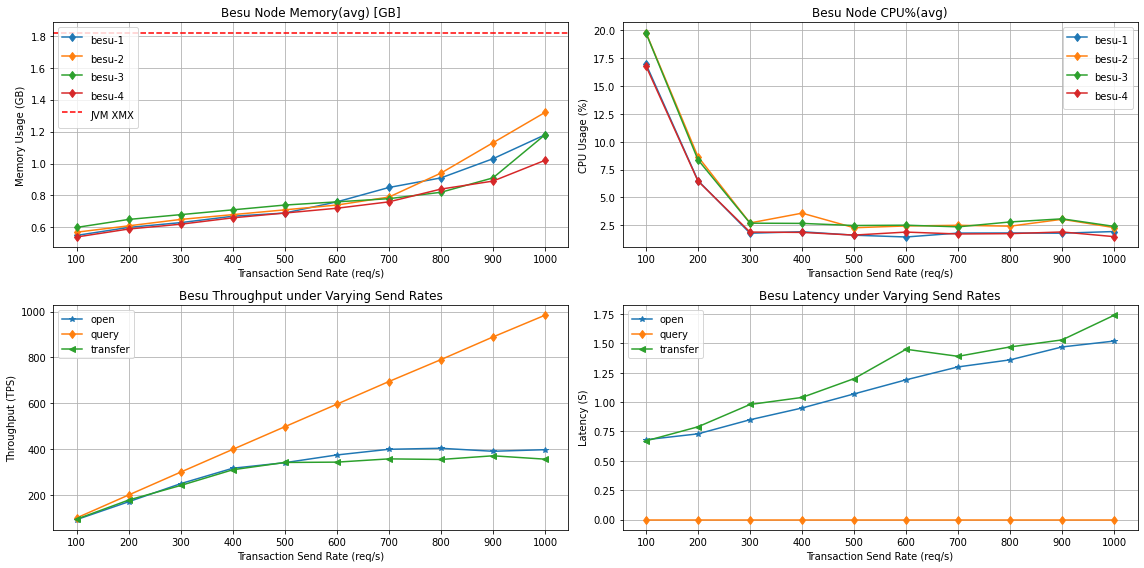

In [2]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/4_LB_2C7.5G_QBFT_1S')

20220413-072032 has 50 reports.
20220413-081436 has 50 reports.
20220413-062628 has 50 reports.
20220413-090853 has 50 reports.
20220413-053204 has 50 reports.


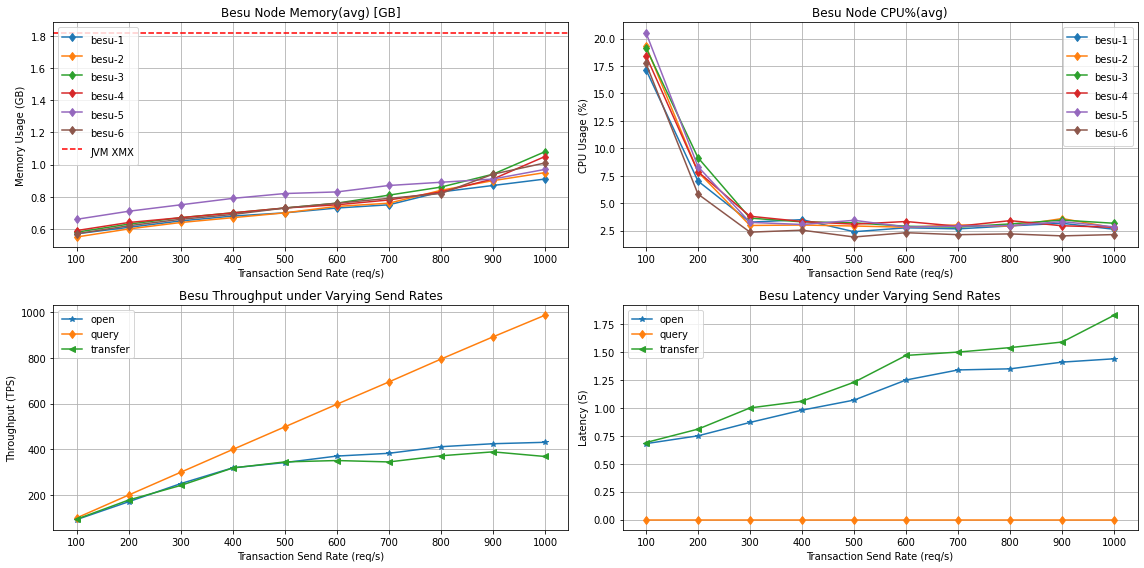

In [4]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/6_LB_2C7.5G_QBFT_1S')

20220411-233402 has 50 reports.
20220411-214147 has 50 reports.
20220411-223857 has 50 reports.
20220411-204628 has 50 reports.
20220412-003103 has 50 reports.


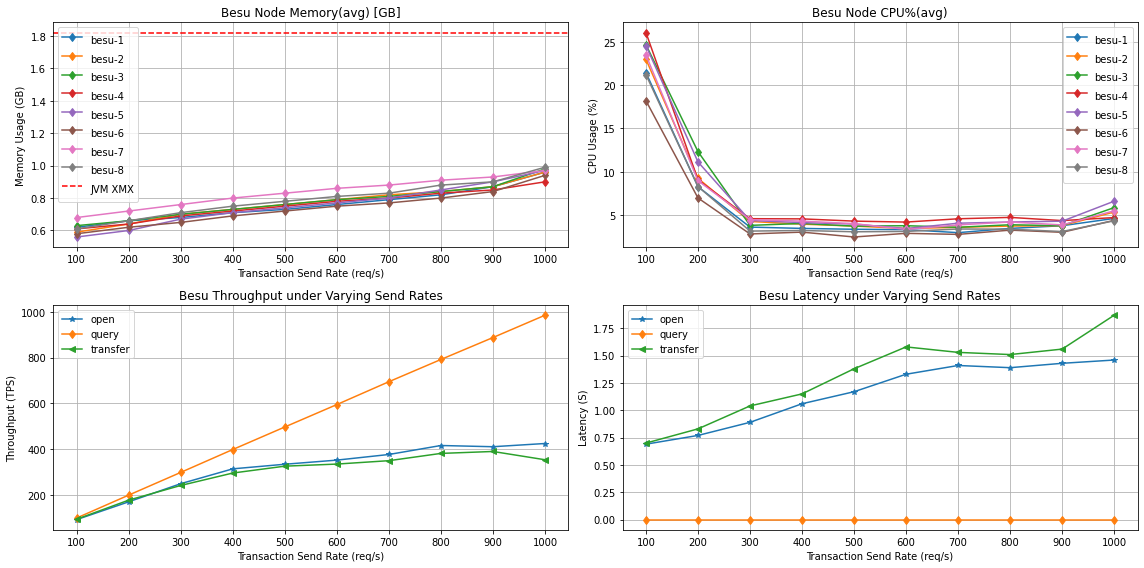

In [3]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')

20220413-115517 has 50 reports.
20220413-110110 has 50 reports.
20220413-134348 has 50 reports.
20220413-100708 has 50 reports.
20220413-124930 has 50 reports.


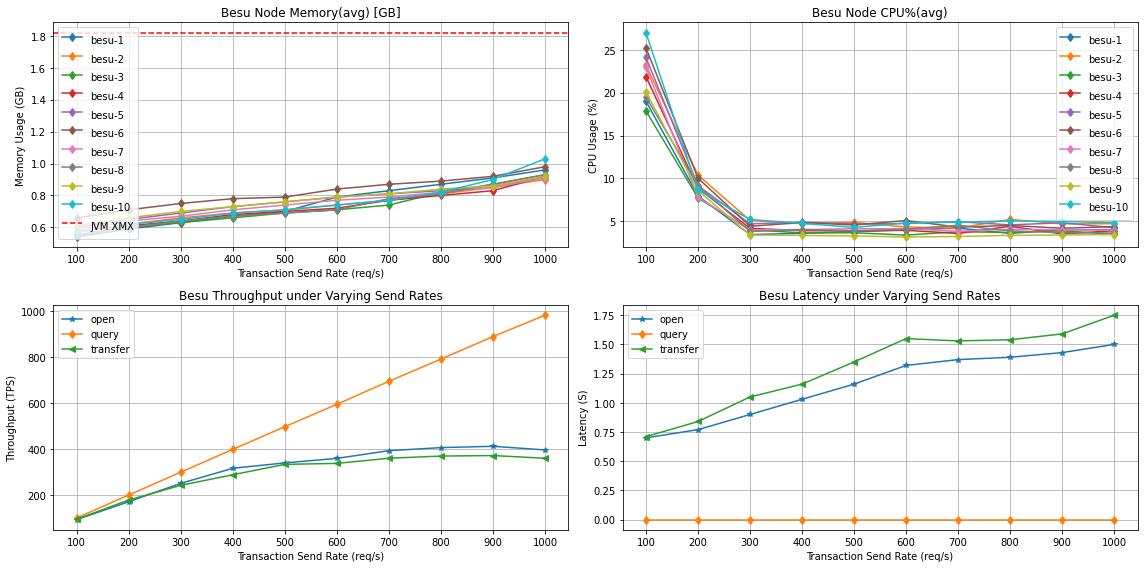

In [5]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/10_LB_2C7.5G_QBFT_1S')

20220413-182005 has 50 reports.
20220413-144224 has 50 reports.
20220413-153657 has 50 reports.
20220413-163129 has 50 reports.
20220413-172545 has 50 reports.


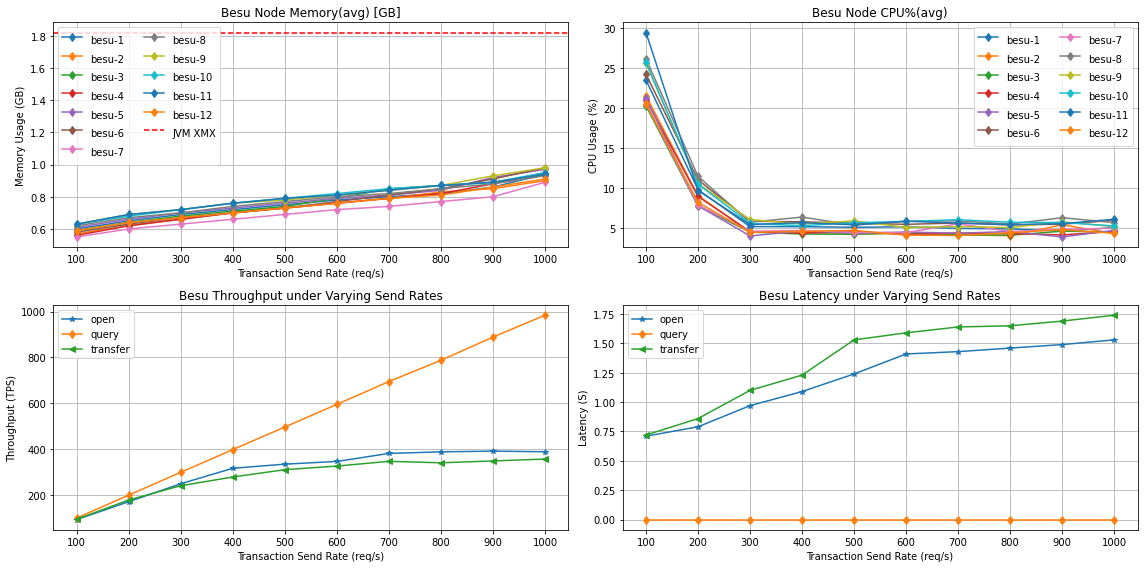

In [6]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/12_LB_2C7.5G_QBFT_1S')

20220413-210837 has 50 reports.
20220413-191908 has 50 reports.
20220413-225752 has 50 reports.
20220413-201403 has 50 reports.
20220413-220321 has 50 reports.


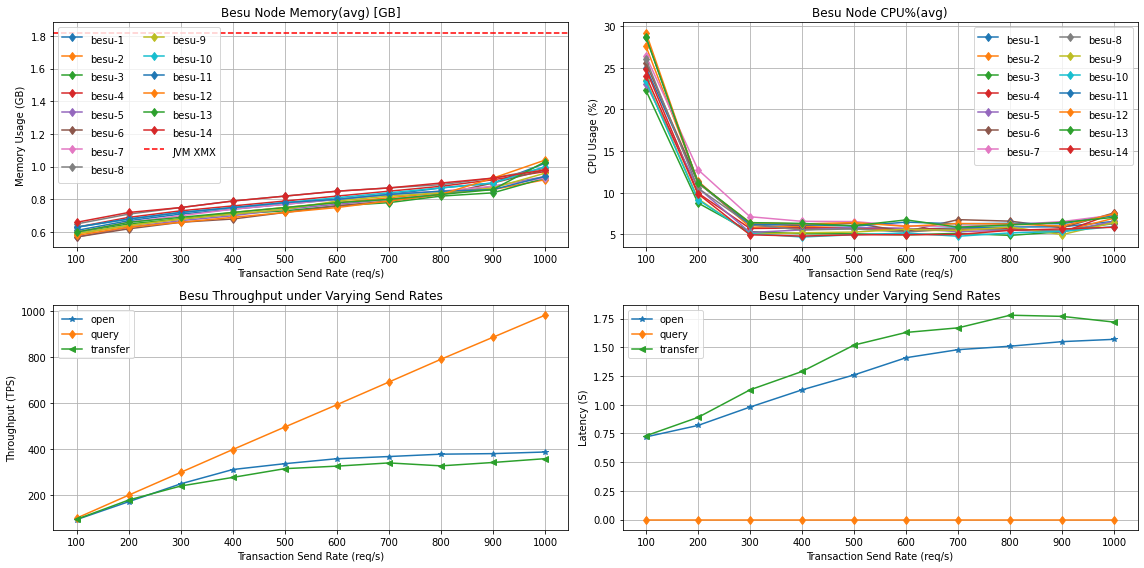

In [7]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/14_LB_2C7.5G_QBFT_1S')

20220414-015008 has 50 reports.
20220414-005444 has 50 reports.
20220414-034128 has 50 reports.
20220413-235907 has 50 reports.
20220414-024548 has 50 reports.


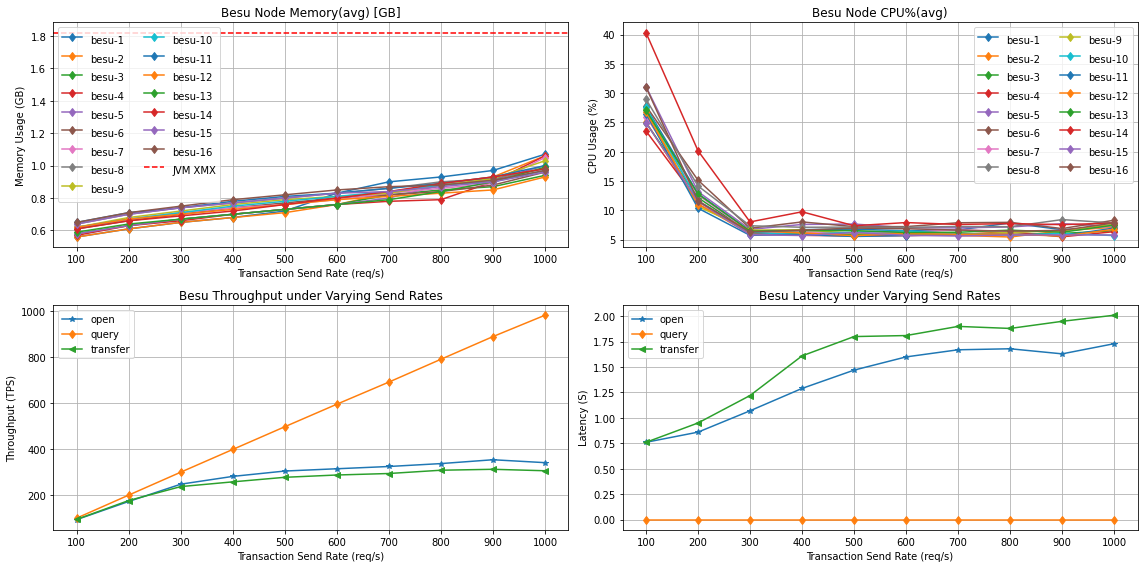

In [8]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/16_LB_2C7.5G_QBFT_1S')

# Scale-up 

20220414-072413 has 50 reports.
20220414-044206 has 50 reports.
20220414-053605 has 50 reports.
20220414-081809 has 50 reports.
20220414-063006 has 50 reports.


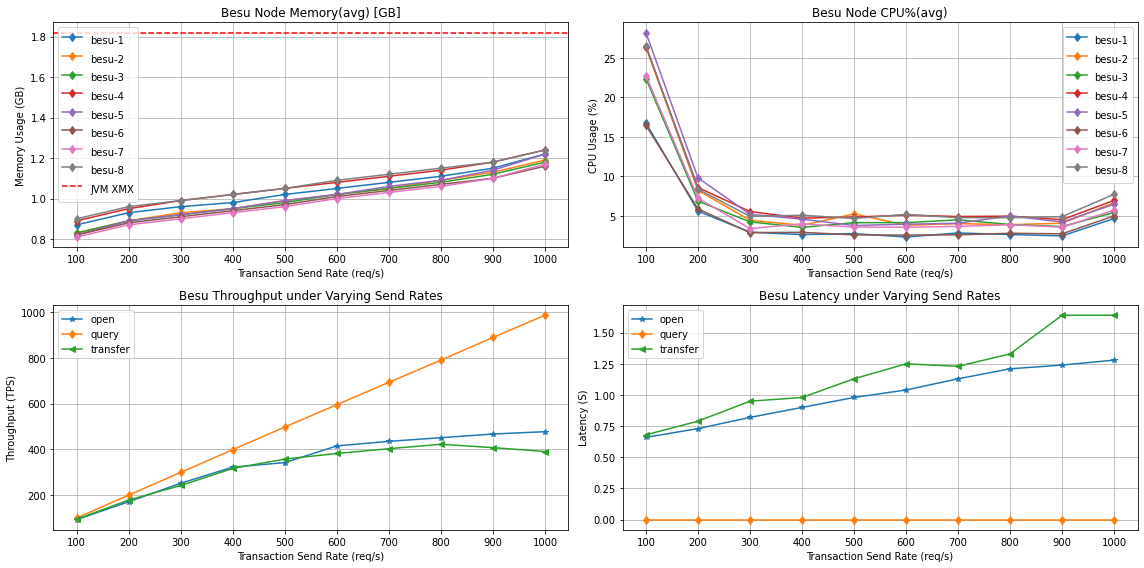

In [2]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_4C15G_QBFT_1S')

In [6]:
# plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_8C30G_QBFT_1S')

20220414-161349 has 50 reports.
20220414-142558 has 50 reports.
20220414-151955 has 50 reports.
20220414-170738 has 50 reports.
20220414-180121 has 50 reports.


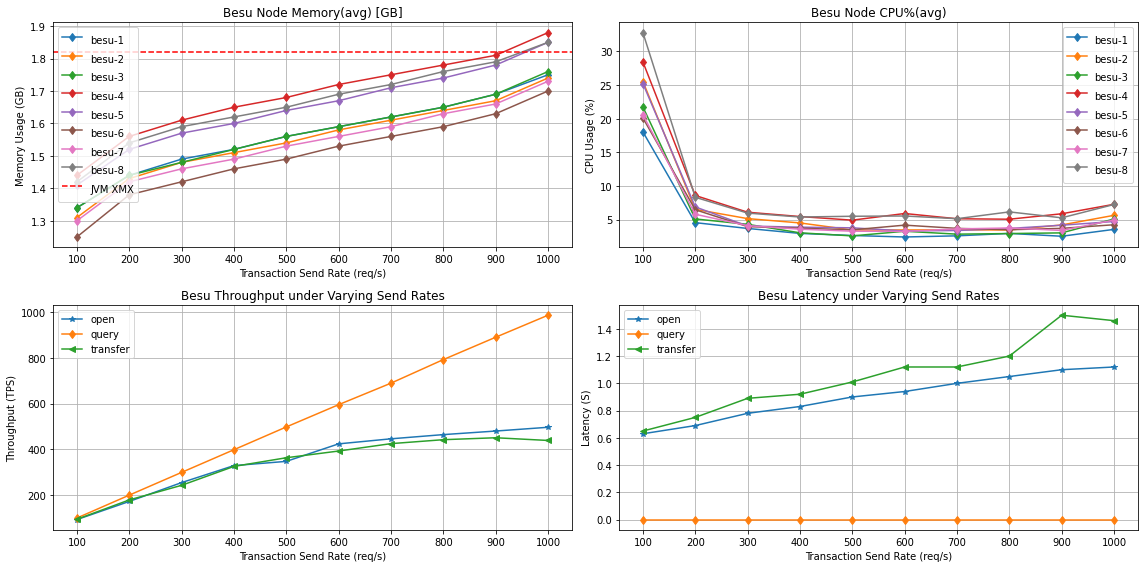

In [5]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_16C60G_QBFT_1S')

# Boxplot

In [185]:
df_perf, df_res = get_res_df_multi_rounds('/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')
df_perf

20220411-233402 has 50 reports.
20220411-214147 has 50 reports.
20220411-223857 has 50 reports.
20220411-204628 has 50 reports.
20220412-003103 has 50 reports.


Name  Succ  Fail  Send Rate (TPS)  Max Latency (s)  Min Latency (s)  \
0       open  1000     0            100.4             1.43             0.19   
1      query  1000     0            100.3             0.06             0.00   
2   transfer  1000     0            100.4             1.34             0.14   
0       open  1000     0            100.4             1.23             0.14   
1      query  1000     0            100.4             0.05             0.00   
..       ...   ...   ...              ...              ...              ...   
1      query  1000     0            879.5             0.03             0.00   
2   transfer  1000     0            892.9             1.97             0.99   
0       open  1000     0            898.5             1.95             0.95   
1      query  1000     0            884.2             0.01             0.00   
2   transfer  1000     0            893.7             1.85             1.02   

    Avg Latency (s)  Throughput (TPS)  Rate  
0              0.78              94.1   100  
1              0.00             100.3   100  
2              0.73              95.4   100  
0              0.68              94.1   100  
1              0.00             100.3   100  
..              ...               ...   ...  
1              0.00             878.7   900  
2              1.49             393.2   900  
0              1.46             402.4   900  
1              0.00             882.6   900  
2              1.43             422.8   900  

[750 rows x 9 columns]

In [200]:
df_perf, df_res = get_res_df_multi_rounds('/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
rates = sorted(df_perf.Rate.unique())
for rate in rates:
    df = df_perf[(df_perf.Name=='open') & (df_perf.Rate==rate)]
    open_lat.append(df['Avg Latency (s)'].values)
    open_tps.append(df['Throughput (TPS)'].values)
    df = df_perf[(df_perf.Name=='transfer') & (df_perf.Rate==rate)]
    transfer_lat.append(df['Avg Latency (s)'].values)
    transfer_tps.append(df['Throughput (TPS)'].values)

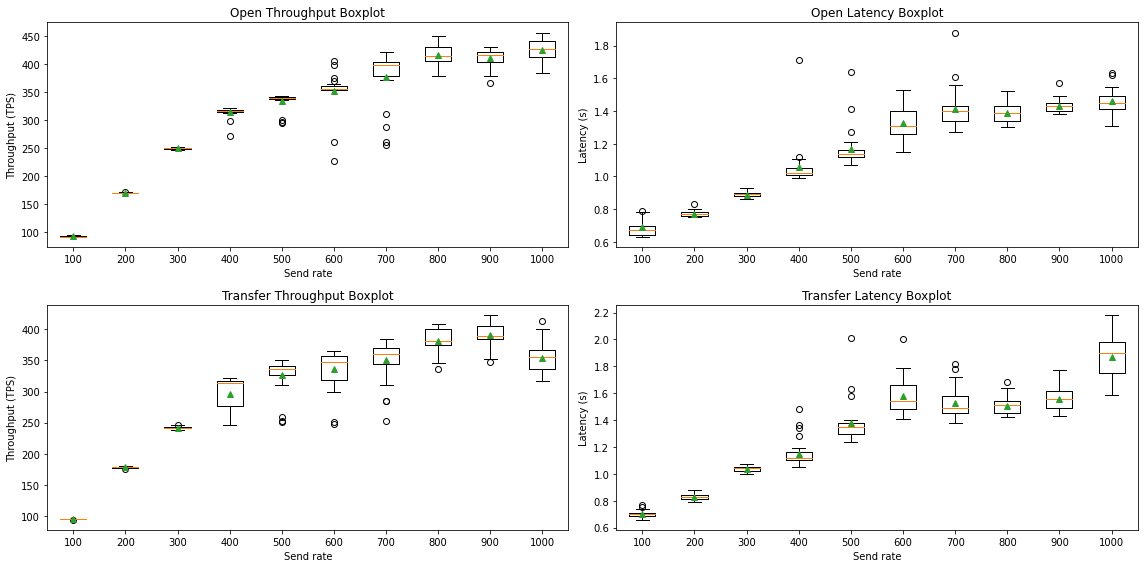

In [206]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
xlabels = np.arange(100, 1100, 100)
positions = np.arange(10) + 1

axes[0][0].boxplot(open_tps, positions=positions, showmeans=True, labels=xlabels)
axes[0][0].set_title("Open Throughput Boxplot")
axes[0][0].set_xlabel('Send rate')
axes[0][0].set_ylabel('Throughput (TPS)')

axes[0][1].boxplot(open_lat, positions=positions, showmeans=True, labels=xlabels)
axes[0][1].set_title("Open Latency Boxplot")
axes[0][1].set_xlabel('Send rate')
axes[0][1].set_ylabel('Latency (s)')

axes[1][0].boxplot(transfer_tps, positions=positions, showmeans=True, labels=xlabels)
axes[1][0].set_title("Transfer Throughput Boxplot")
axes[1][0].set_xlabel('Send rate')
axes[1][0].set_ylabel('Throughput (TPS)')

axes[1][1].boxplot(transfer_lat, positions=positions, showmeans=True, labels=xlabels)
axes[1][1].set_title("Transfer Latency Boxplot")
axes[1][1].set_xlabel('Send rate')
axes[1][1].set_ylabel('Latency (s)')
plt.tight_layout()
plt.show()

# Consensus

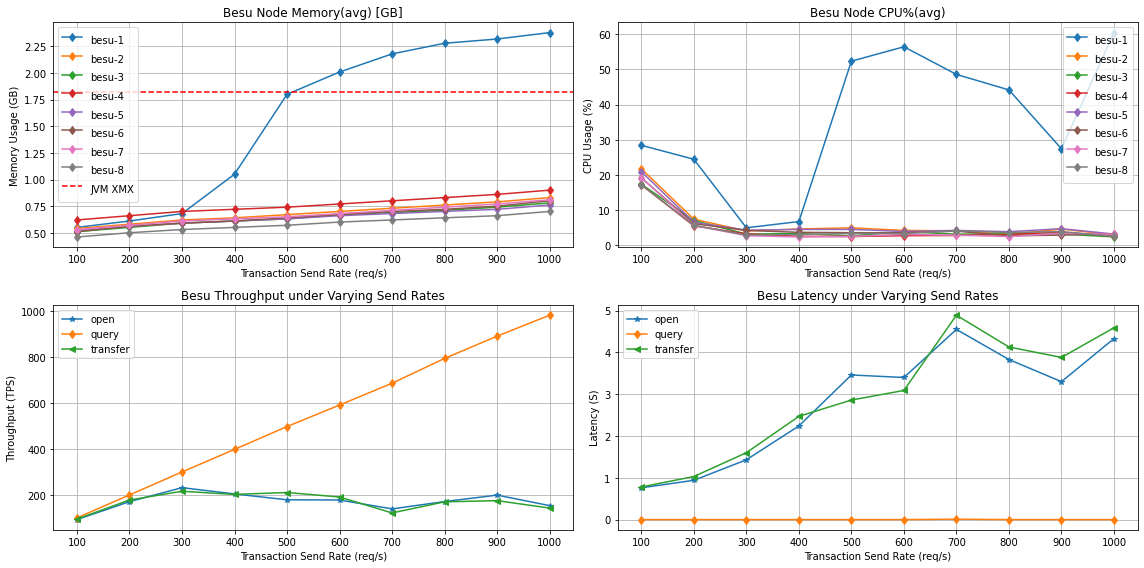

In [180]:
plot(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_NLB_2C7.5G_QBFT_1S/20220412-021244')

20220412-061726 has 34 reports.
20220412-094356 has 50 reports.
20220412-021244 has 50 reports.
20220412-104645 has 50 reports.
20220412-031423 has 50 reports.
20220412-114737 has 50 reports.
20220412-041522 has 50 reports.
20220412-135322 has 50 reports.
20220412-084301 has 50 reports.
20220412-051639 has 50 reports.
20220412-145555 has 22 reports.
20220412-125010 has 50 reports.


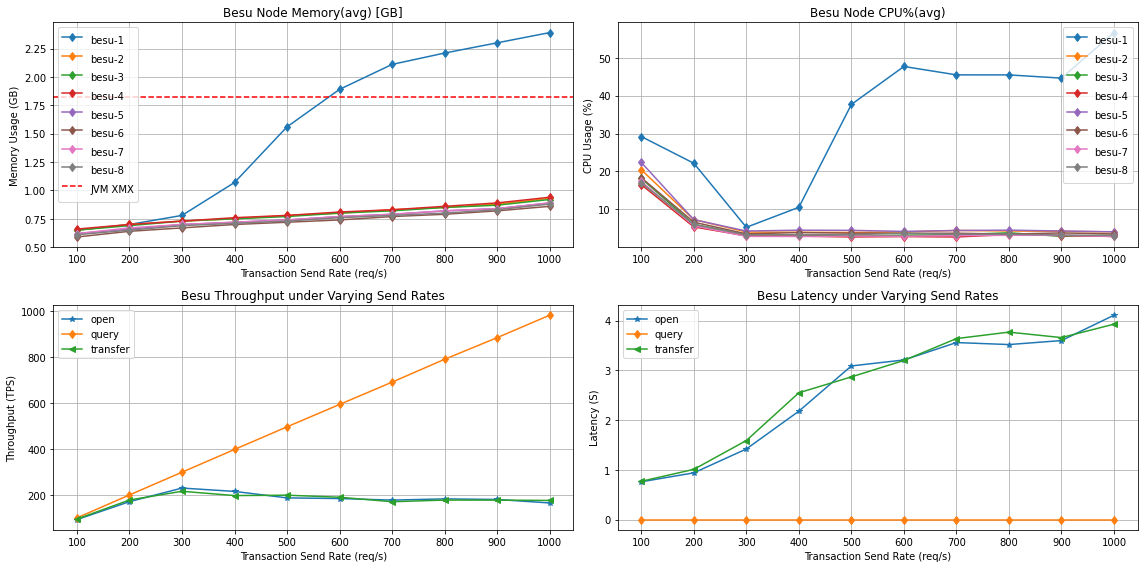

In [181]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_NLB_2C7.5G_QBFT_1S')

20220411-233402 has 50 reports.
20220411-214147 has 50 reports.
20220411-223857 has 50 reports.
20220411-204628 has 50 reports.
20220412-003103 has 50 reports.


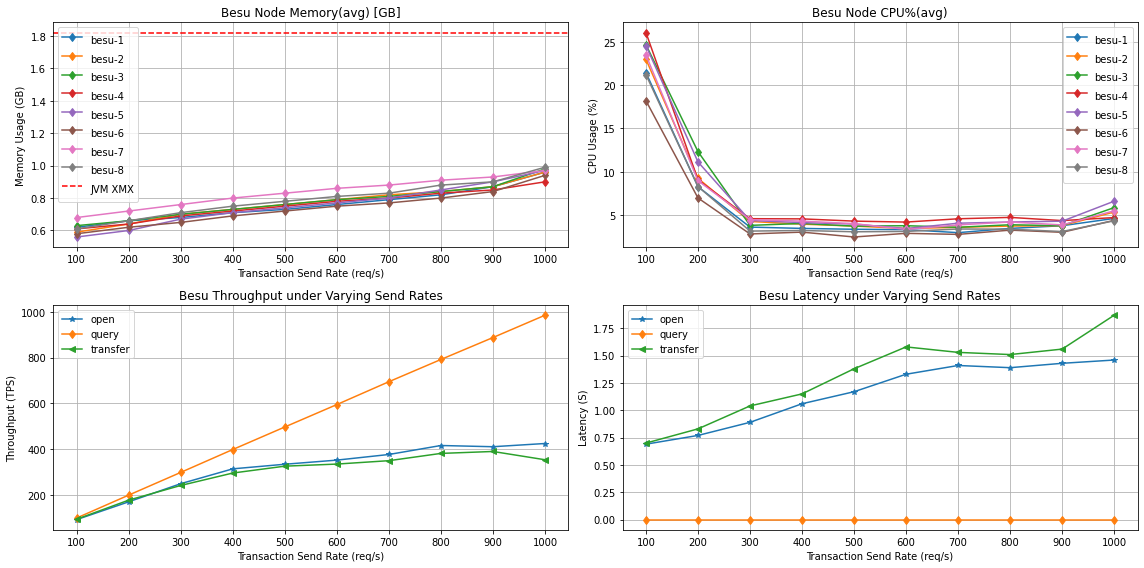

In [182]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')

20220412-184937 has 50 reports.
20220412-175548 has 50 reports.
20220412-203728 has 50 reports.
20220412-170135 has 50 reports.
20220412-194330 has 50 reports.


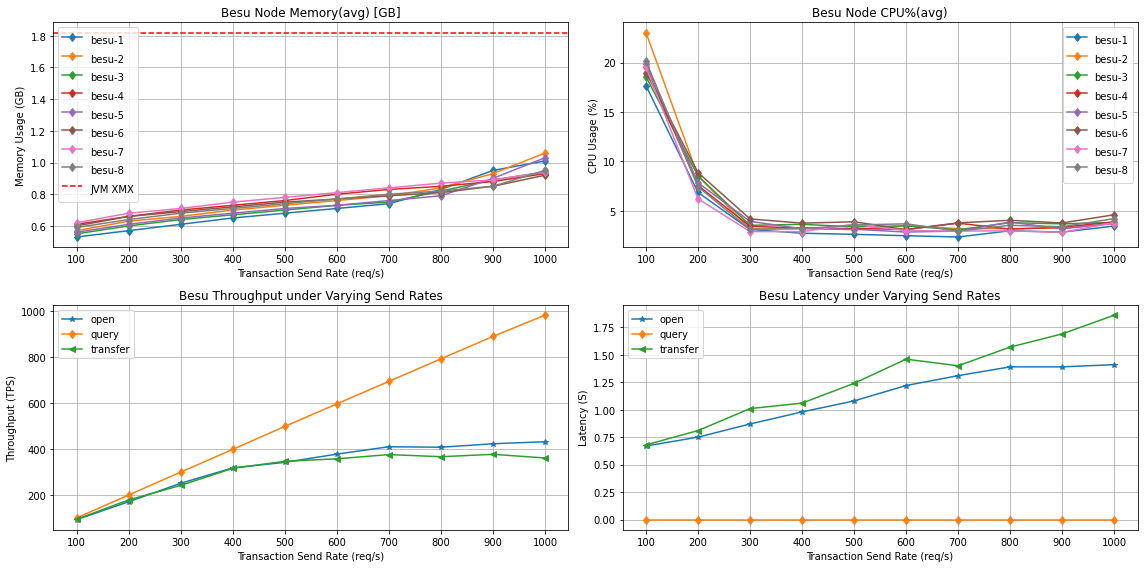

In [183]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_IBFT2_1S')

# 2c-7.5gb

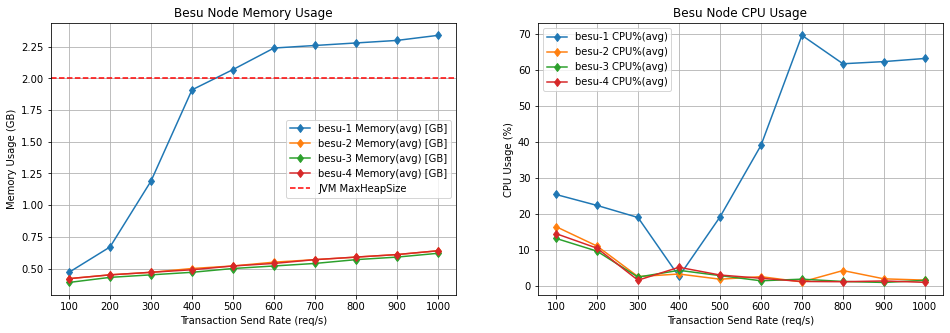

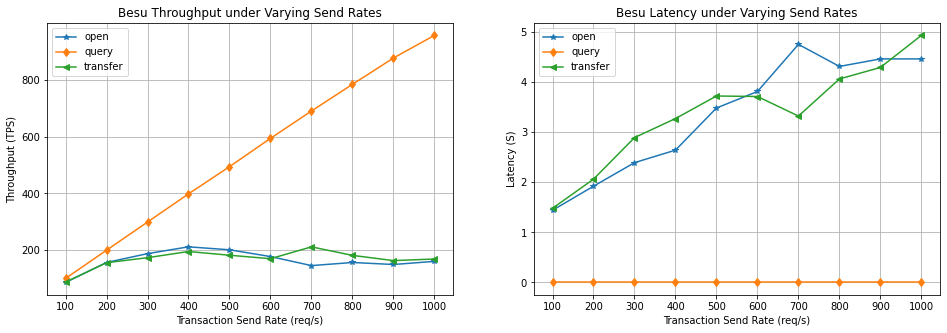

In [3]:
# small node 2c-7.5gb
plot(reports_path = '../caliper-benchmarks/reports/20220307-165330-2c7.5gb-4')

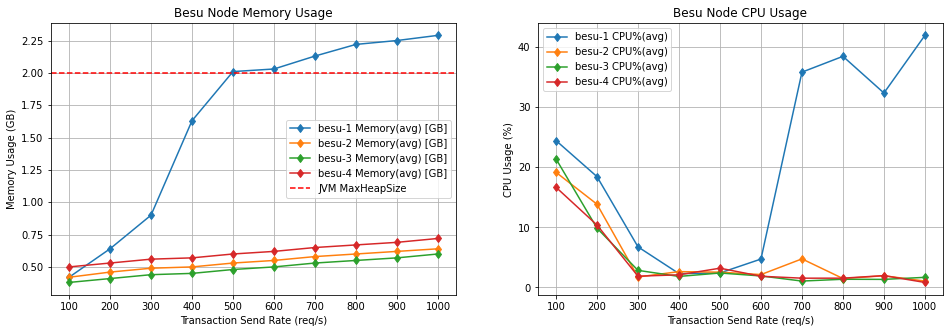

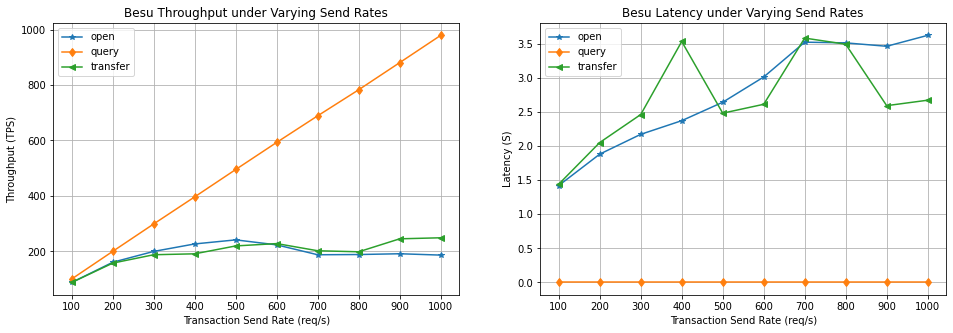

In [4]:
# small node 2c-7.5gb with maxrampercentage=80.0
plot(reports_path = '../caliper-benchmarks/reports/20220322-172941-4n-2c7.5gb-ram80')

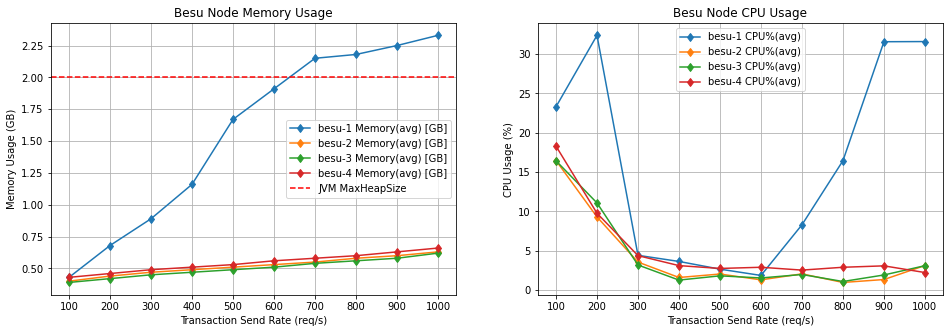

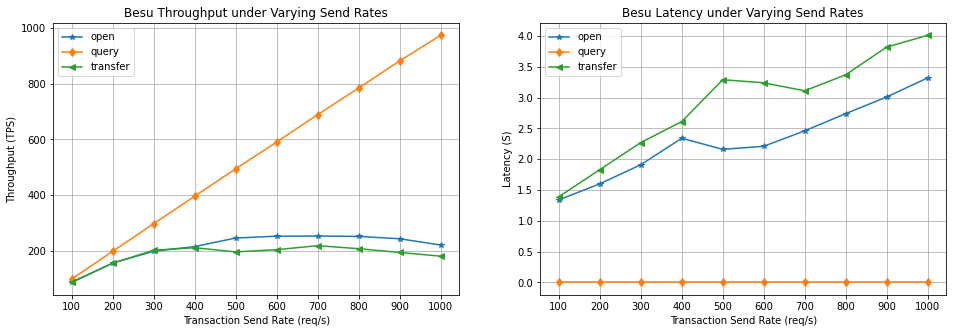

In [4]:
# small node 2c-7.5gb with maxrampercentage=50.0
plot(reports_path = '../caliper-benchmarks/reports/20220323-181854-4n-2c7.5gb-ram50')

## XMX=25 N=4

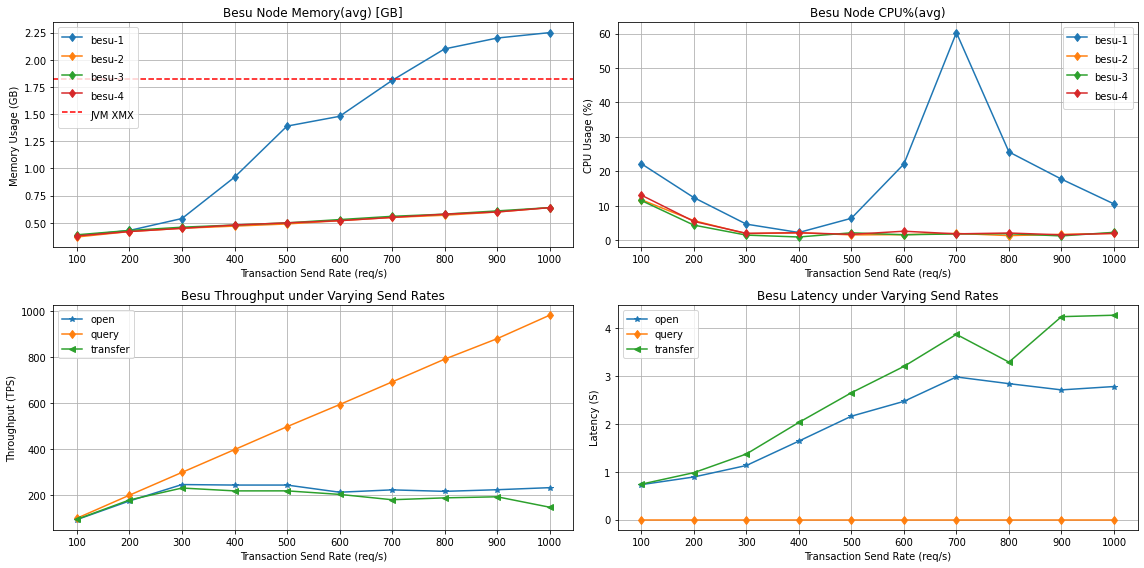

In [8]:
plot(reports_path='../caliper-benchmarks/reports/20220411-010854', jvm_max_heap=1.82)

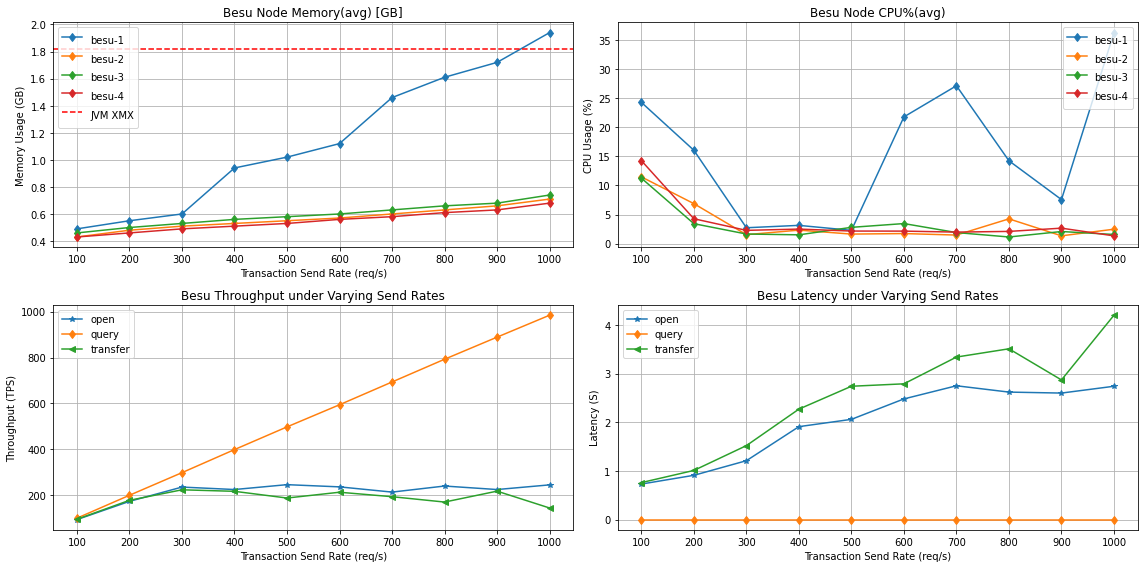

In [10]:
plot(reports_path='../caliper-benchmarks/reports/20220411-032028', jvm_max_heap=1.82)

## 50% MaxRamPercentage

VM settings:
    Max. Heap Size (Estimated): 3.64G
    Using VM: OpenJDK 64-Bit Server VM

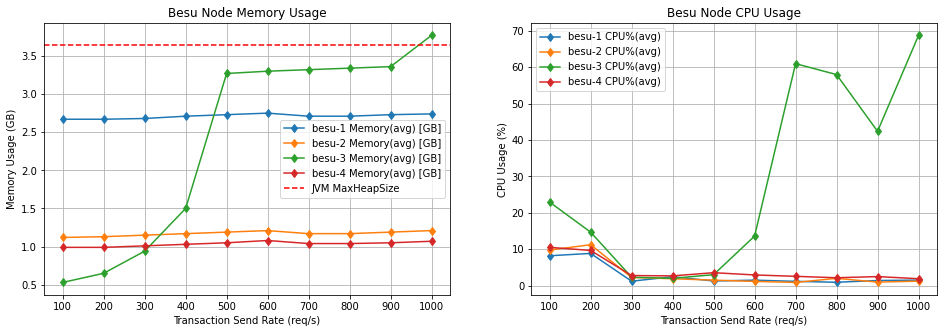

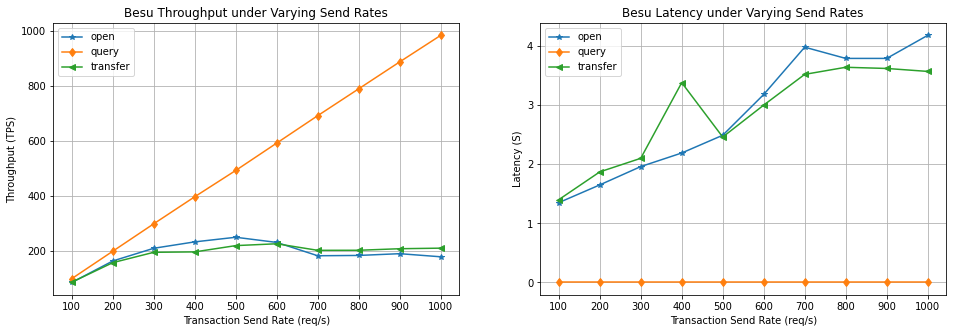

In [3]:
# small node 2c-7.5gb with maxrampercentage=50.0
plot(reports_path = '../caliper-benchmarks/reports/20220326-003930-4n-2c-7.5gb-50ram')

## 80% MaxRamPercentage
VM settings:
    Max. Heap Size (Estimated): 5.83G
    Using VM: OpenJDK 64-Bit Server VM

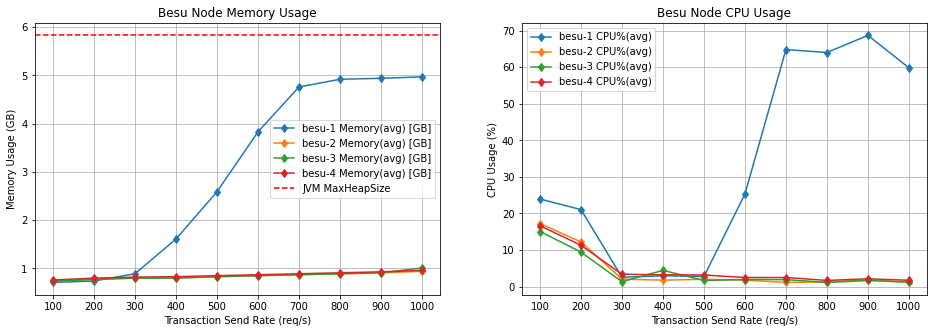

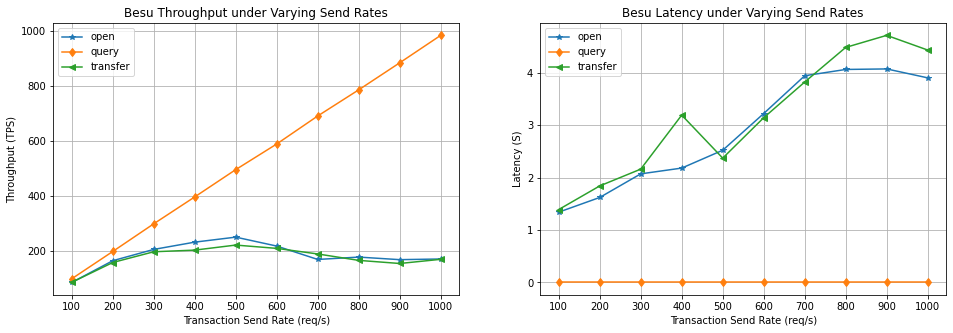

In [8]:
# small node 2c-7.5gb with maxrampercentage=80.0
plot(reports_path = '../caliper-benchmarks/reports/20220328-151933-4n-2c7.5gb-80ram')


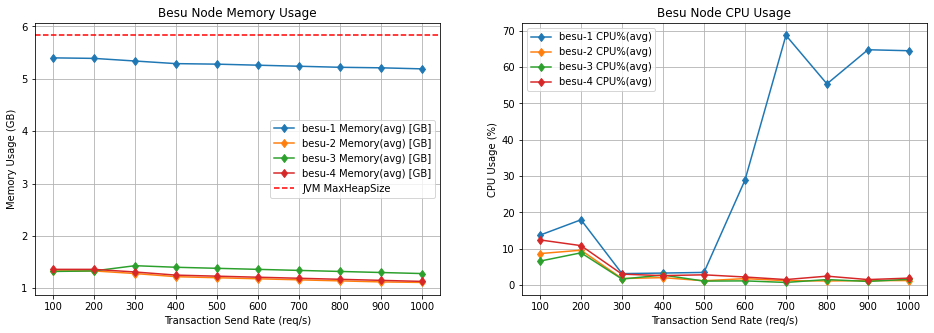

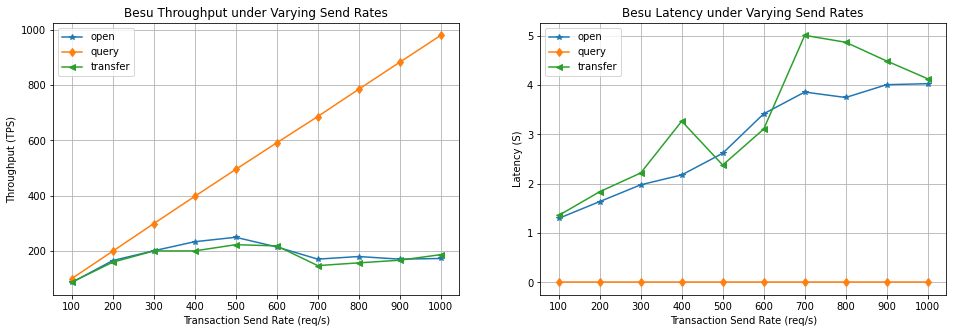

In [6]:
# small node 2c-7.5gb with maxrampercentage=80.0
plot(reports_path = '../caliper-benchmarks/reports/20220328-193603')

## Multiple Clients

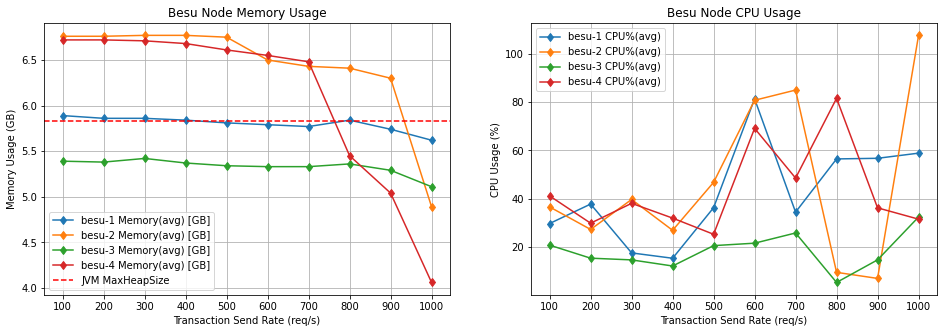

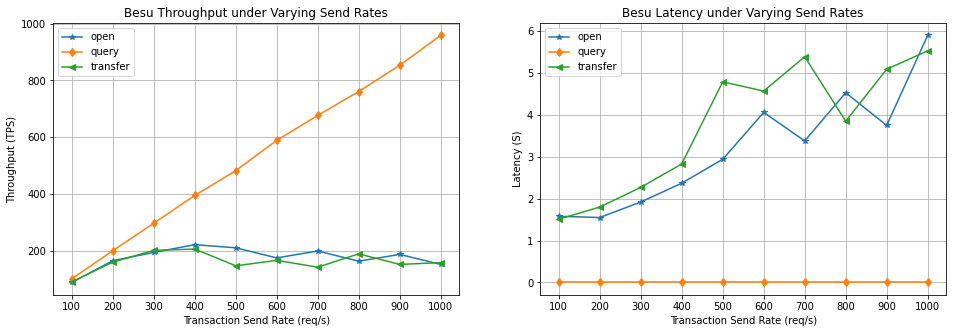

In [3]:
# small node 2c-7.5gb with maxrampercentage=80.0 multiple calipers
# client-1
plot(reports_path = '../caliper-benchmarks/reports/20220329-211507-4n-2c7.5gb-80ram-client1')

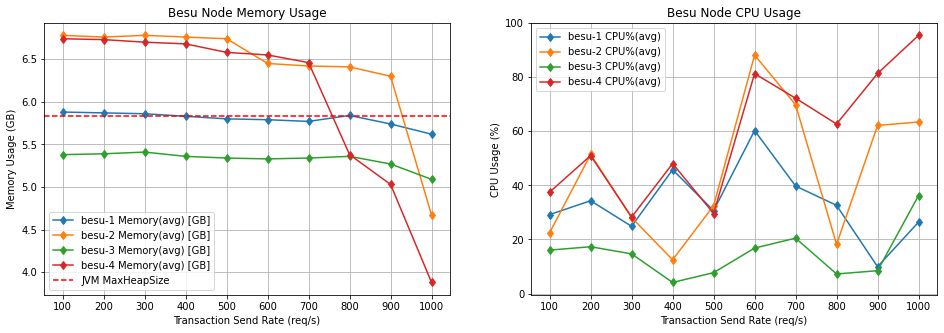

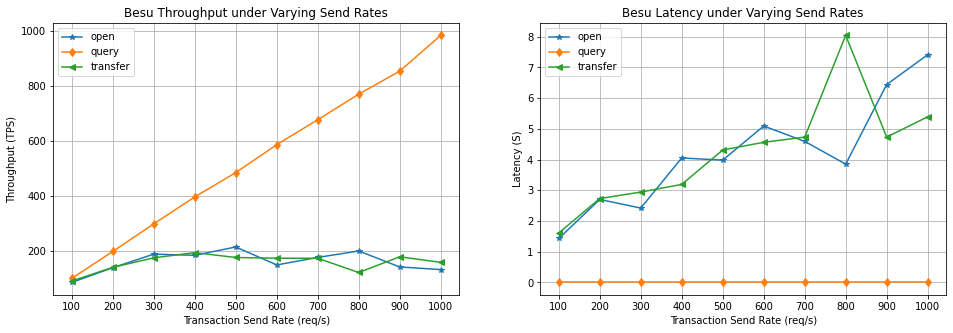

In [4]:
# small node 2c-7.5gb with maxrampercentage=80.0 multiple calipers
# client-4
plot(reports_path = '../caliper-benchmarks/reports/20220329-211509-4n-2c7.5gb-80ram-client4')

## Load Balance - 4nodes - 1s

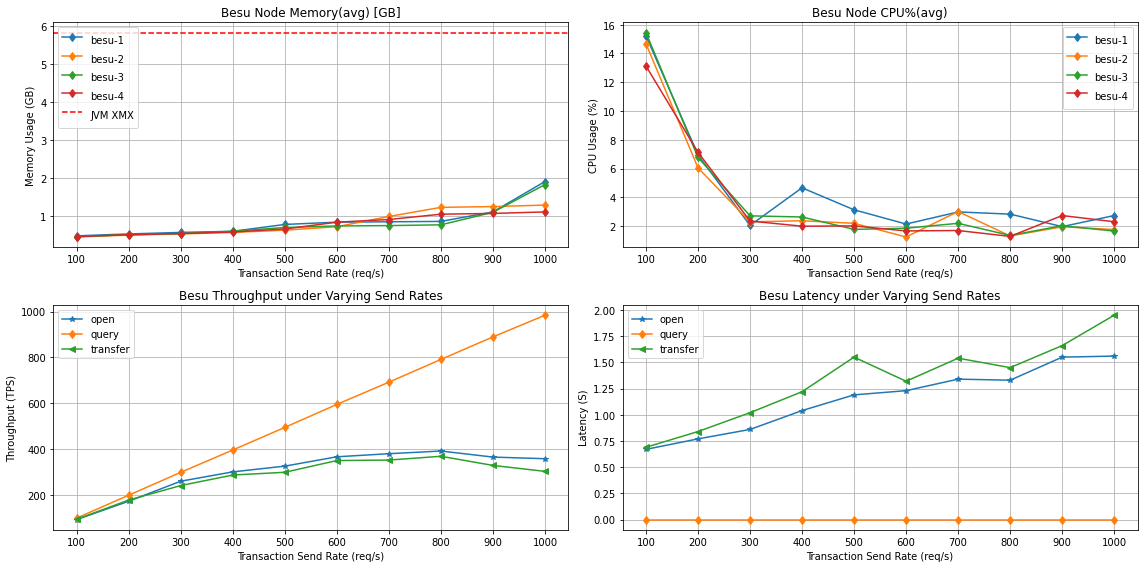

In [7]:
plot(reports_path='../caliper-benchmarks/reports/lb-4n/20220401-042101')

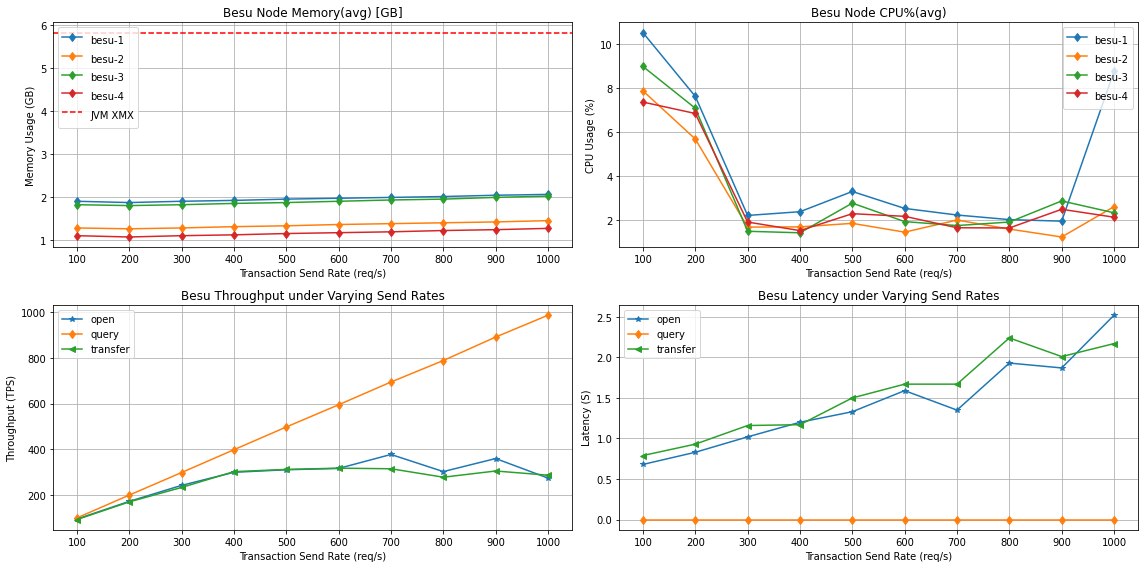

In [8]:
plot(reports_path='../caliper-benchmarks/reports/lb-4n/20220401-051823')

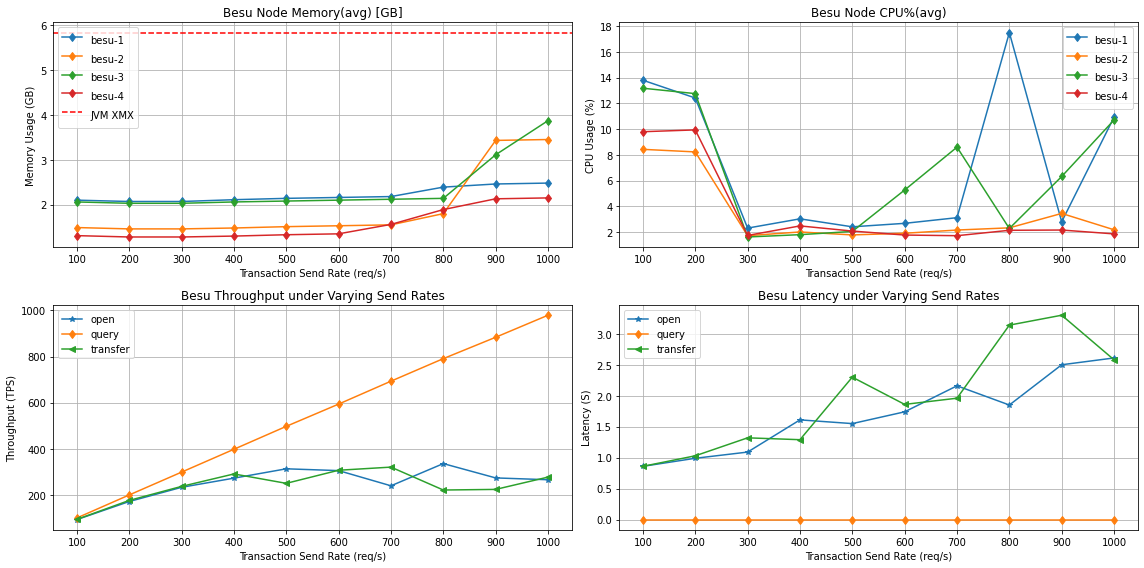

In [9]:
plot(reports_path='../caliper-benchmarks/reports/lb-4n/20220401-061626')

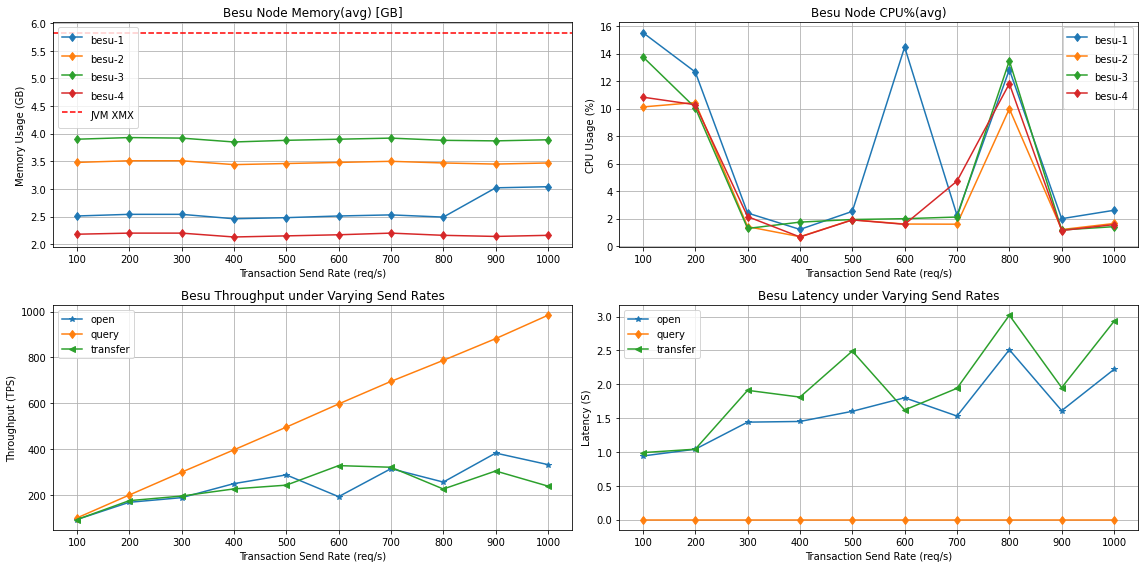

In [10]:
plot(reports_path='../caliper-benchmarks/reports/lb-4n/20220401-071529')

## non-Load Balance - 4nodes - 1s

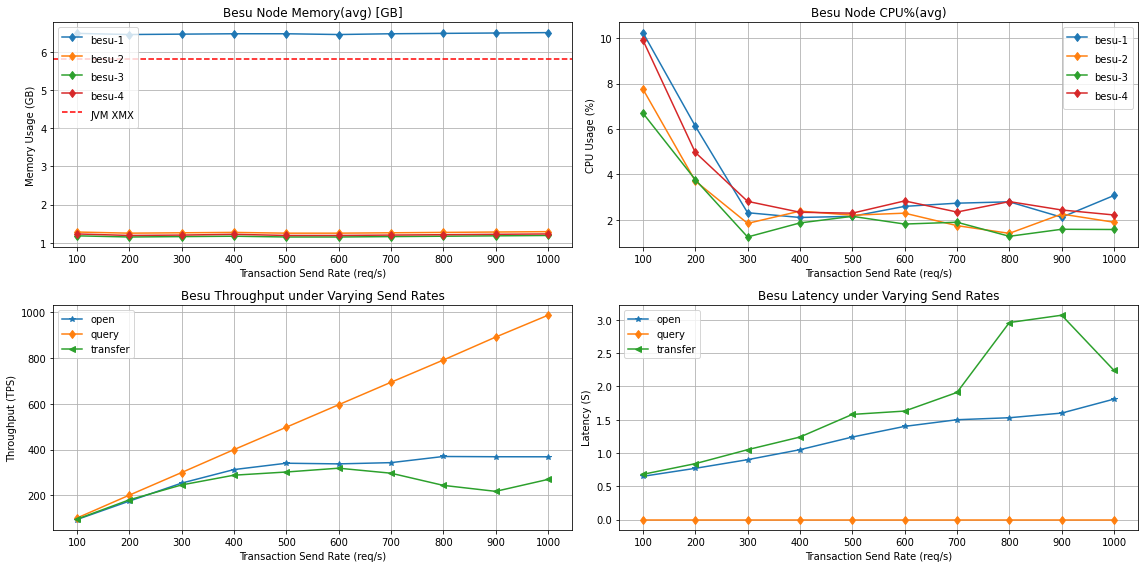

In [12]:
plot(reports_path='../caliper-benchmarks/reports/nlb-4n/20220403-004417')

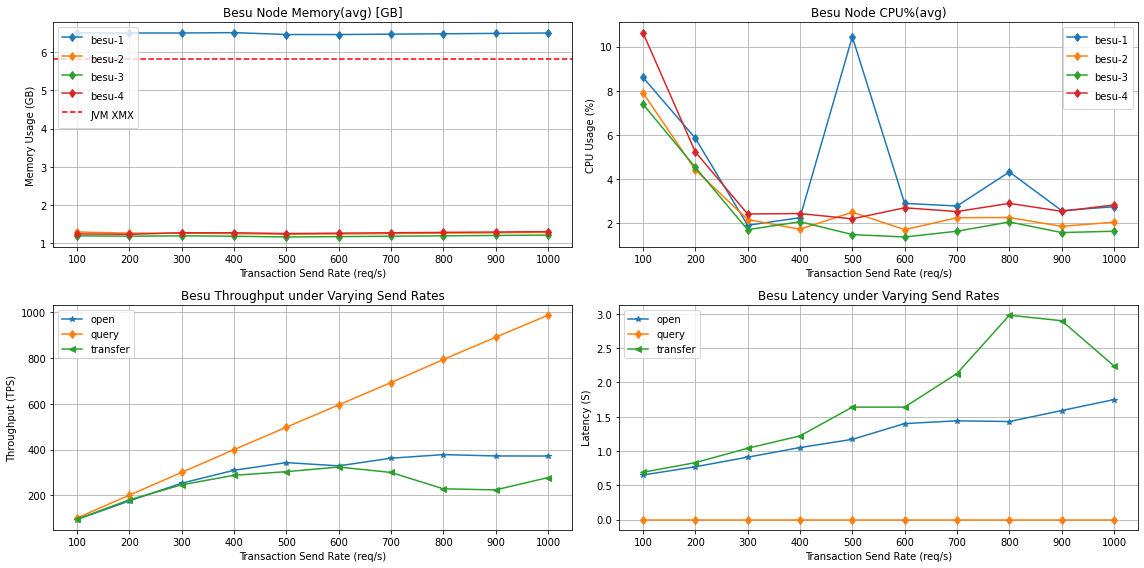

In [13]:
plot(reports_path='../caliper-benchmarks/reports/nlb-4n/20220403-014206')

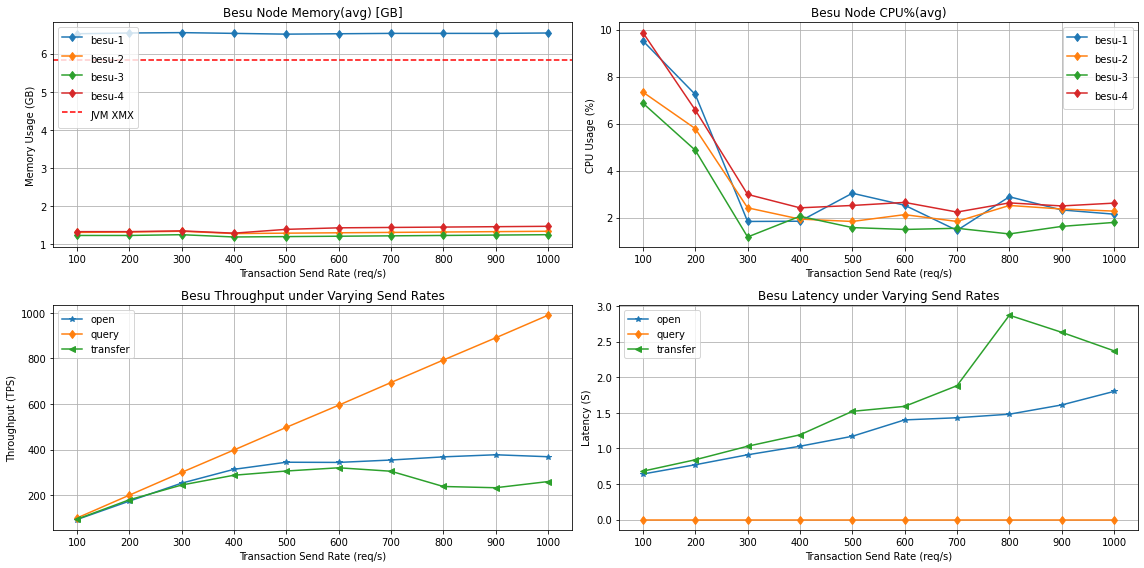

In [14]:
plot(reports_path='../caliper-benchmarks/reports/nlb-4n/20220403-023951')

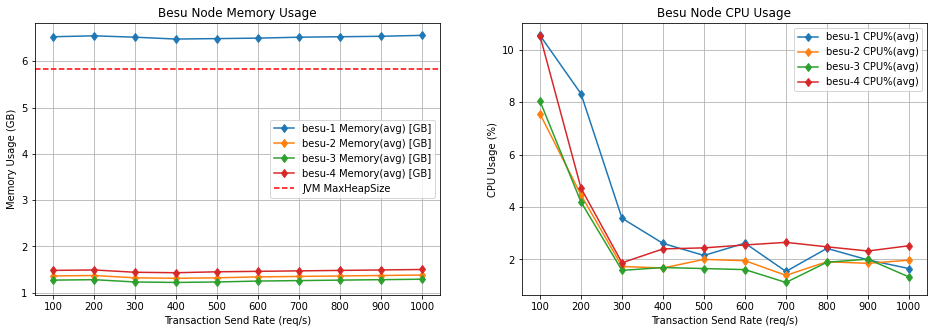

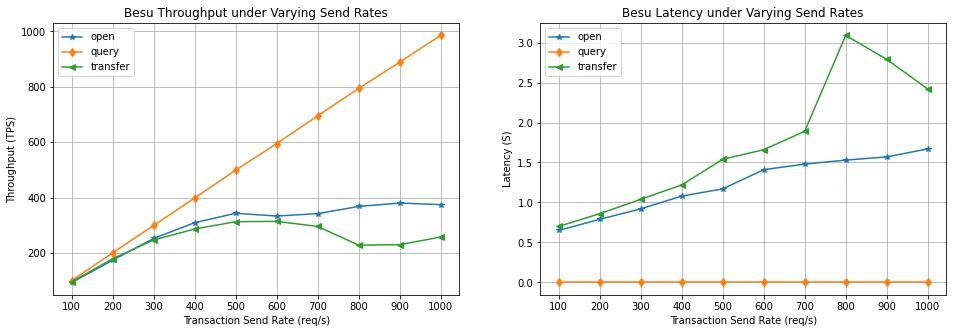

In [6]:
plot(reports_path='./caliper-benchmarks/reports/nlb-4n/20220403-004417')

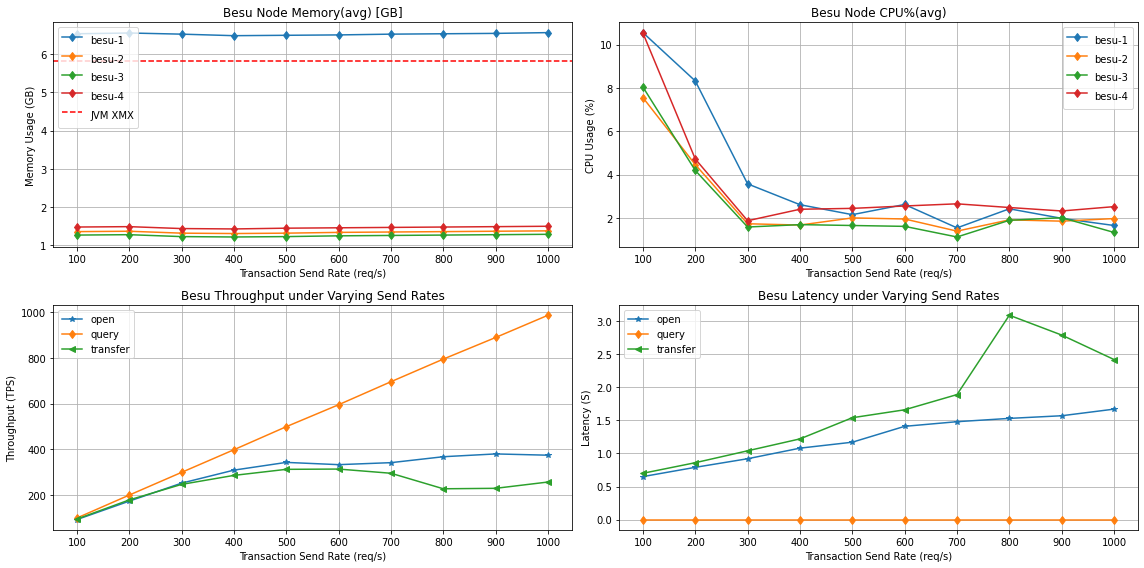

In [15]:
plot(reports_path='../caliper-benchmarks/reports/nlb-4n/20220403-033746')

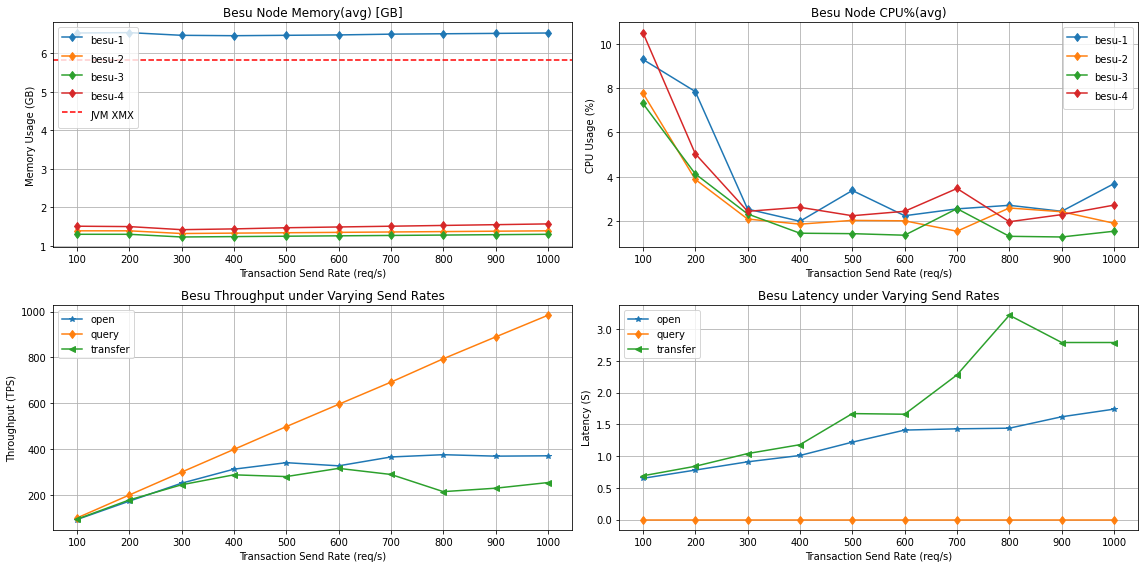

In [16]:
plot(reports_path='../caliper-benchmarks/reports/nlb-4n/20220403-043525')

## Load Balance - 16nodes - 1s

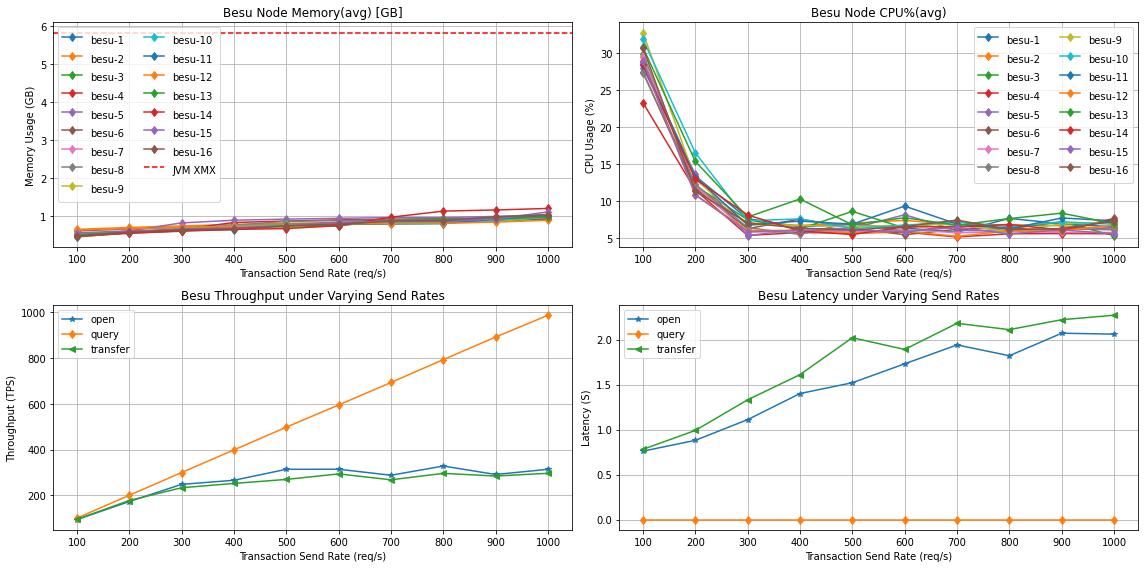

In [9]:
plot(reports_path = '../caliper-benchmarks/reports/20220404-214356')

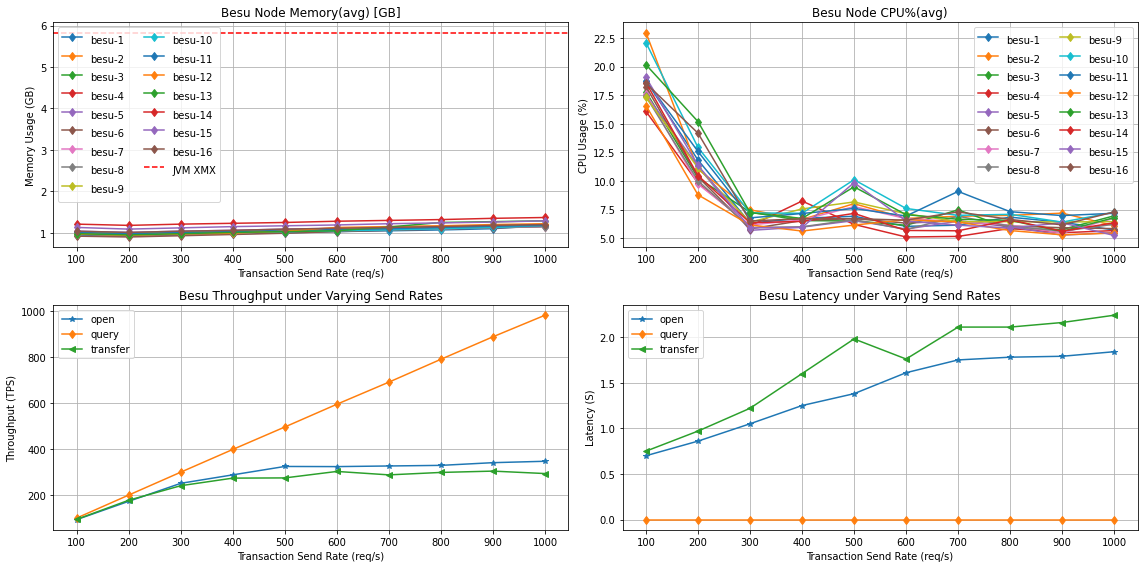

In [12]:
plot(reports_path='../caliper-benchmarks/reports/20220404-224431')

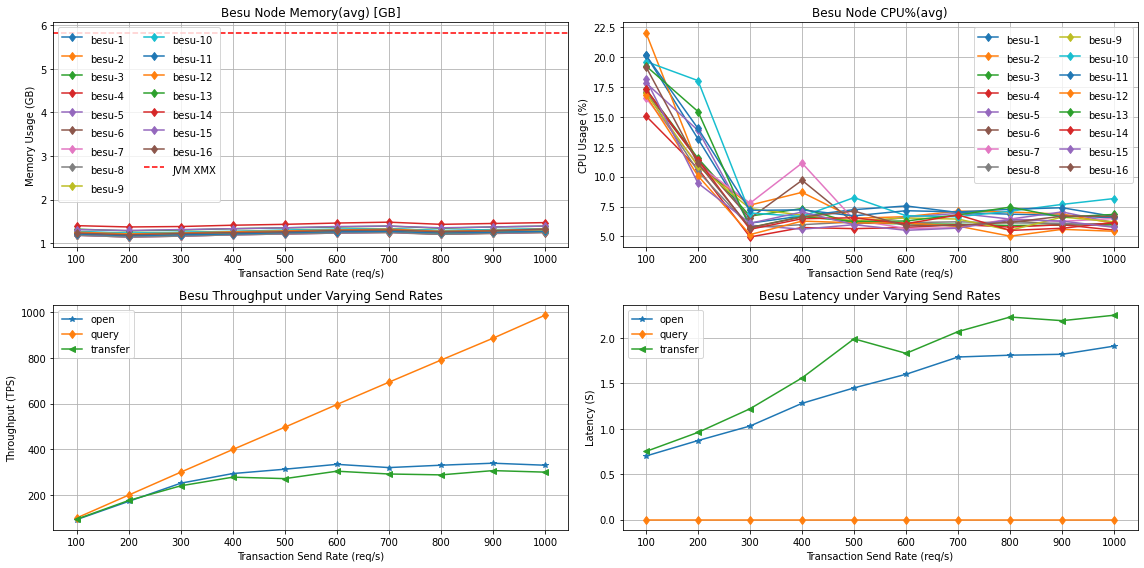

In [10]:
plot(reports_path='../caliper-benchmarks/reports/20220404-234153')

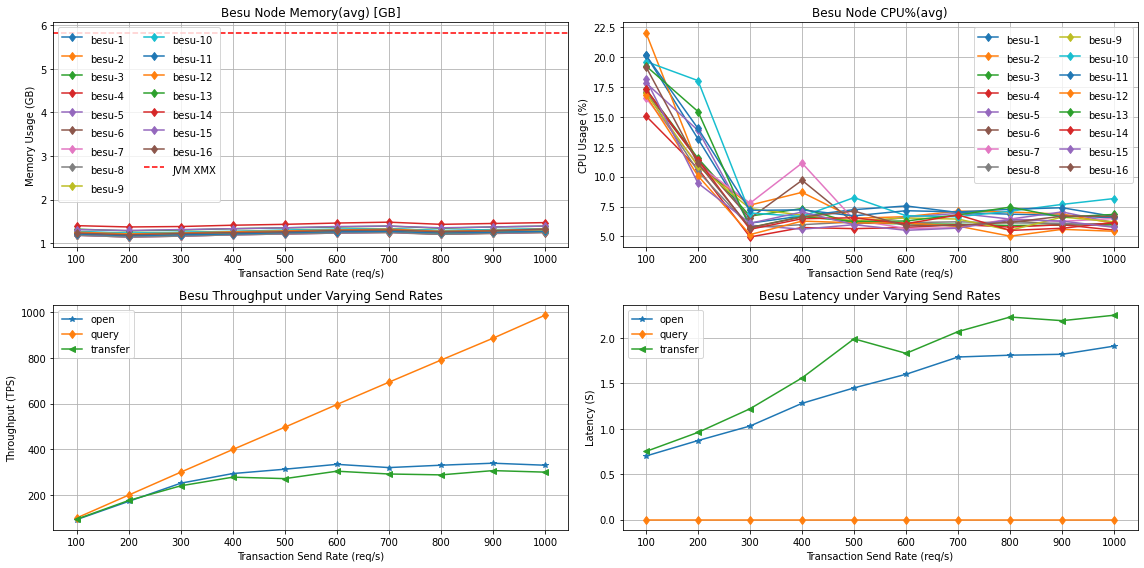

In [11]:
plot(reports_path='../caliper-benchmarks/reports/20220404-234153')

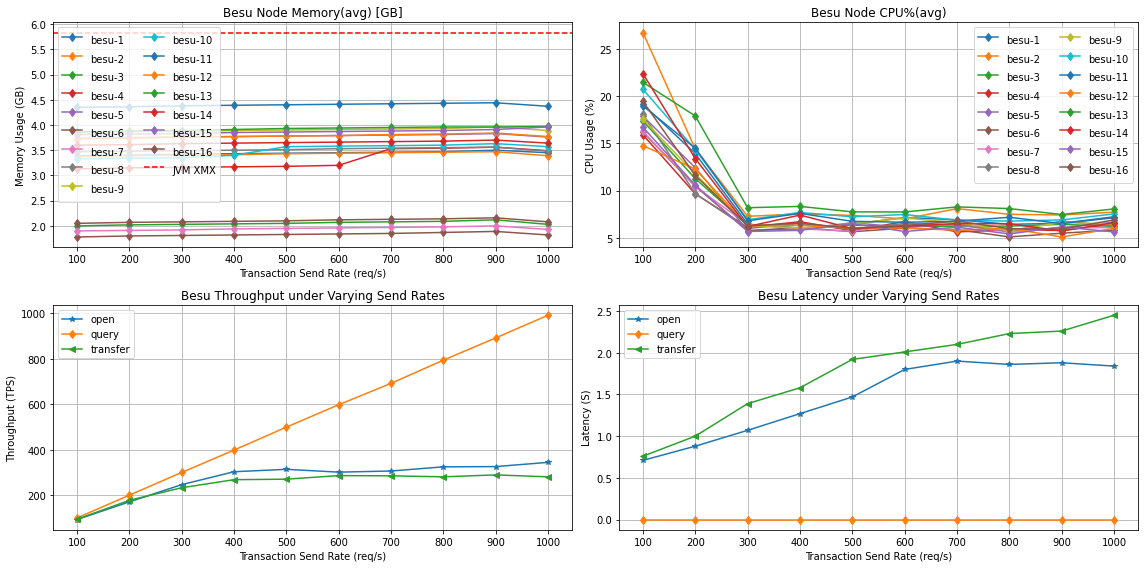

In [14]:
plot(reports_path='../caliper-benchmarks/reports/20220405-150916')

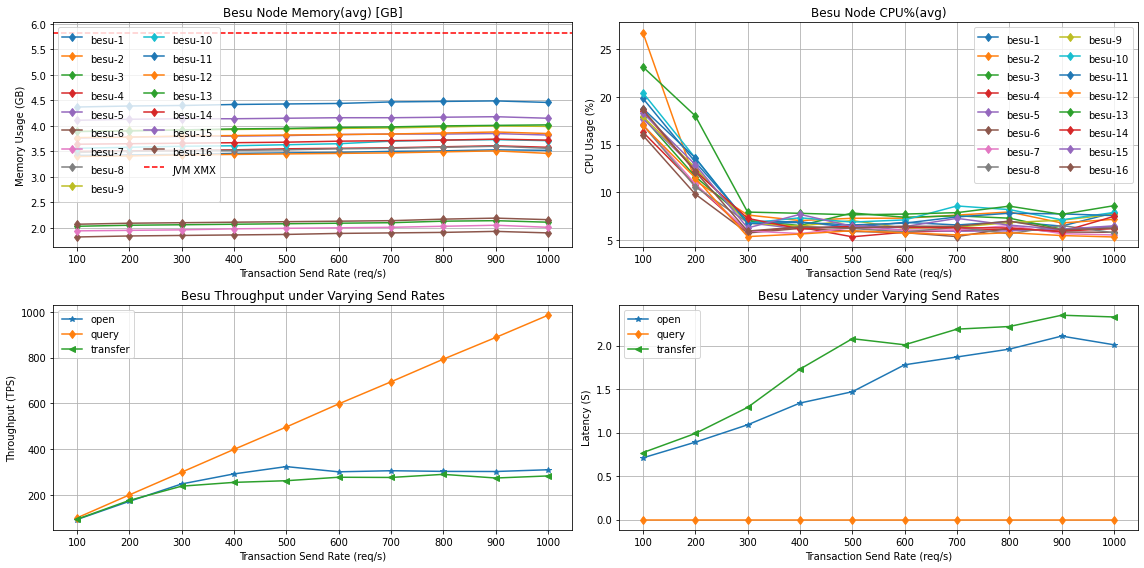

In [13]:
plot(reports_path='../caliper-benchmarks/reports/20220405-160654')

## Non-Load Balance - 16nodes - 1s

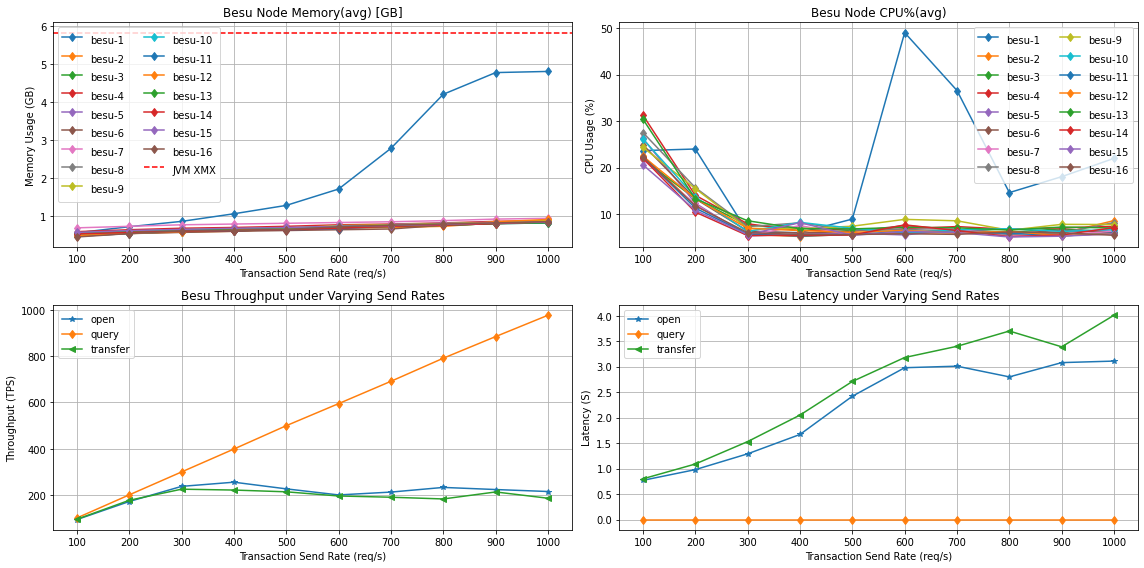

In [6]:
plot(reports_path='../caliper-benchmarks/reports/nlb-16n-1s/20220405-201423')

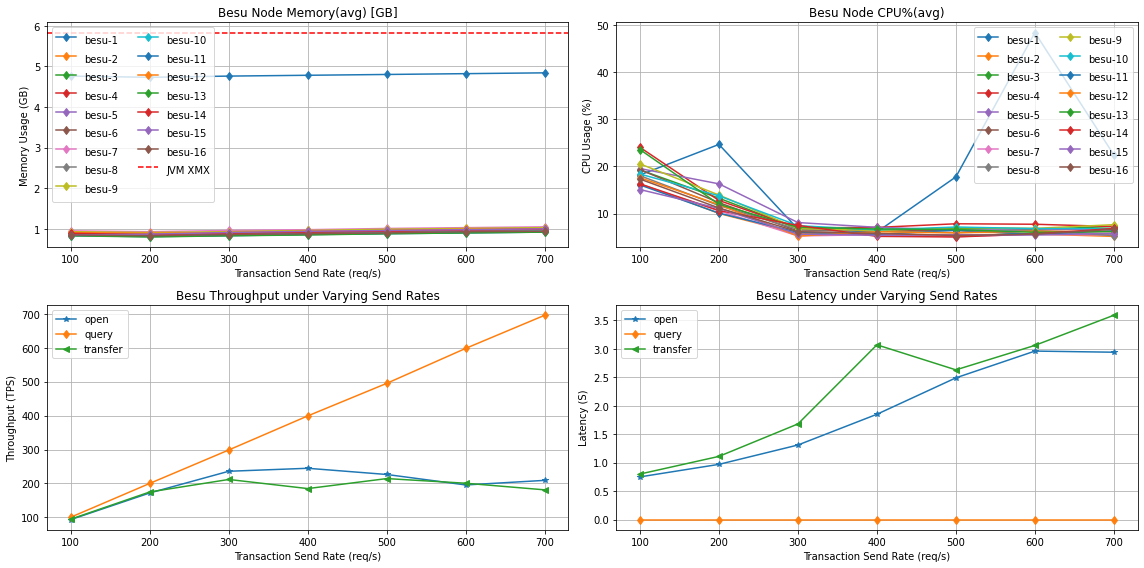

In [7]:
plot(reports_path='../caliper-benchmarks/reports/nlb-16n-1s/20220405-211350')

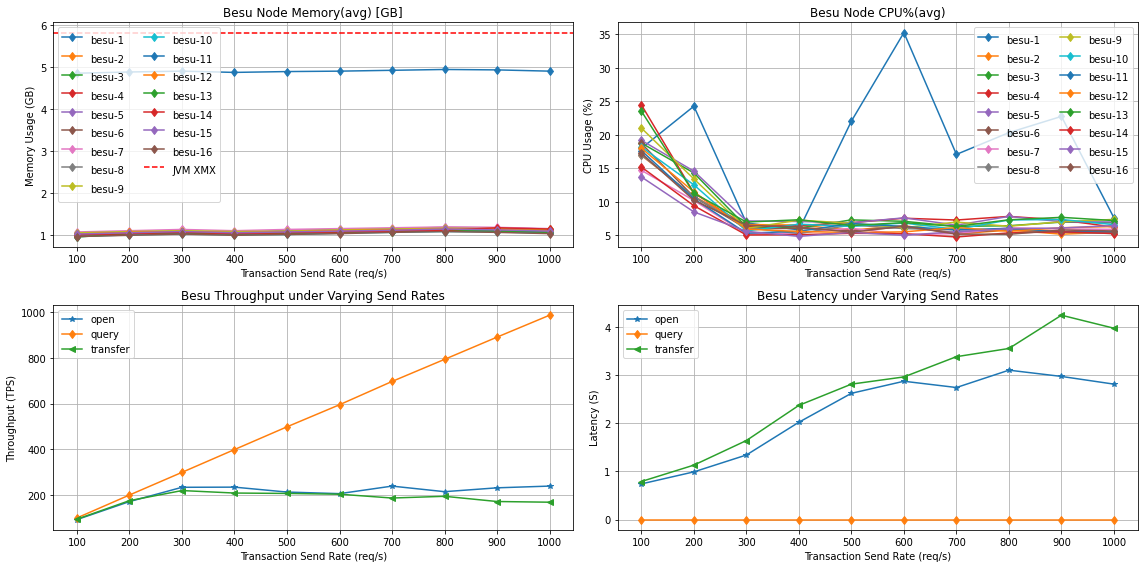

In [8]:
plot(reports_path='../caliper-benchmarks/reports/nlb-16n-1s/20220405-221212')

## Non-Load Balance - 8nodes

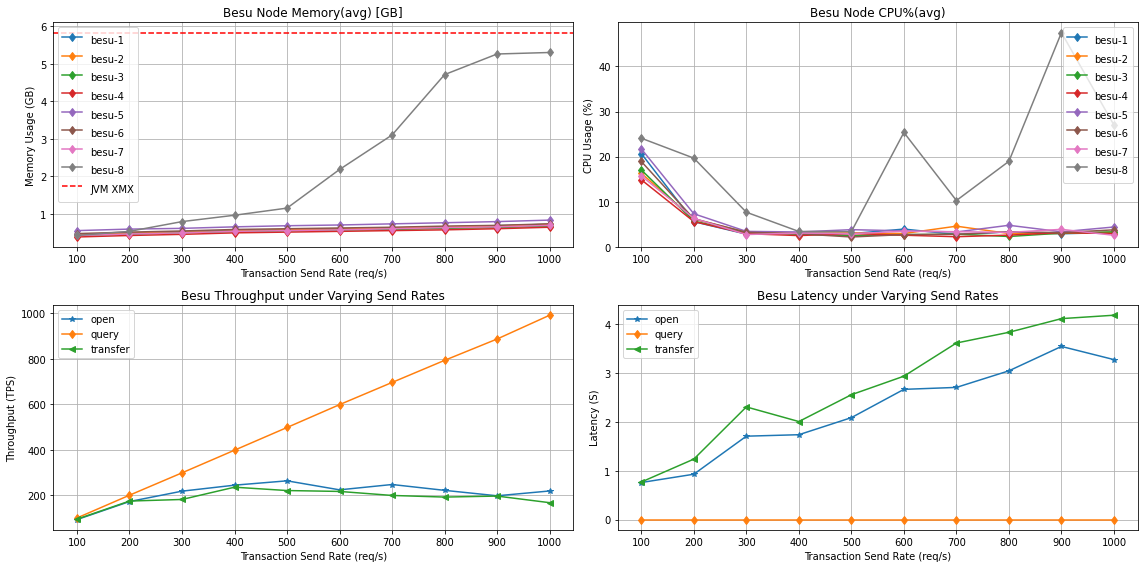

In [3]:
plot(reports_path='../caliper-benchmarks/reports/nlb-8n/20220406-170416')

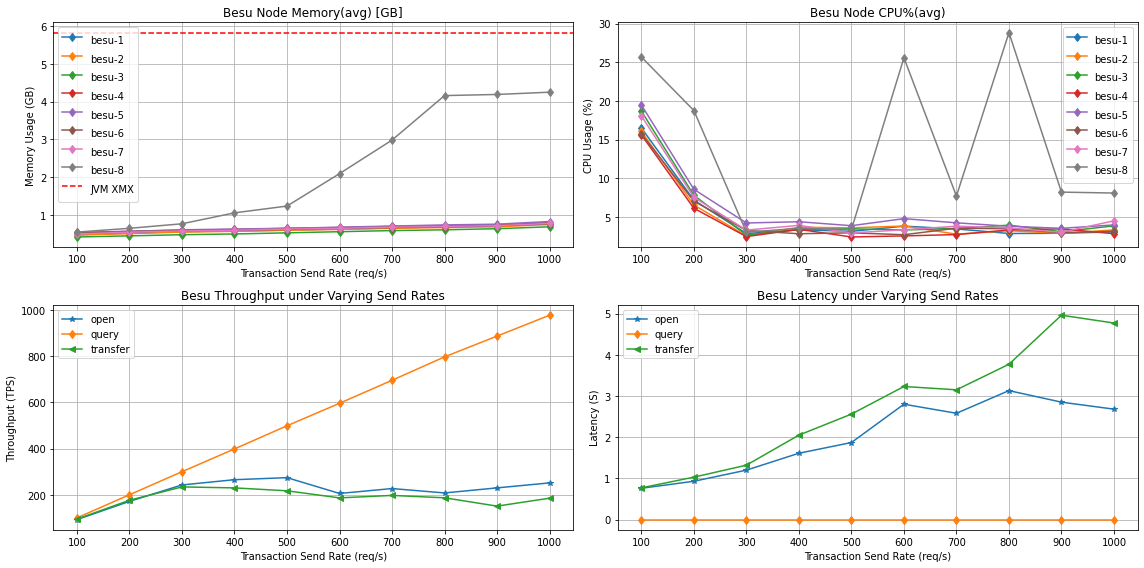

In [4]:
plot(reports_path='../caliper-benchmarks/reports/nlb-8n/20220406-180433')

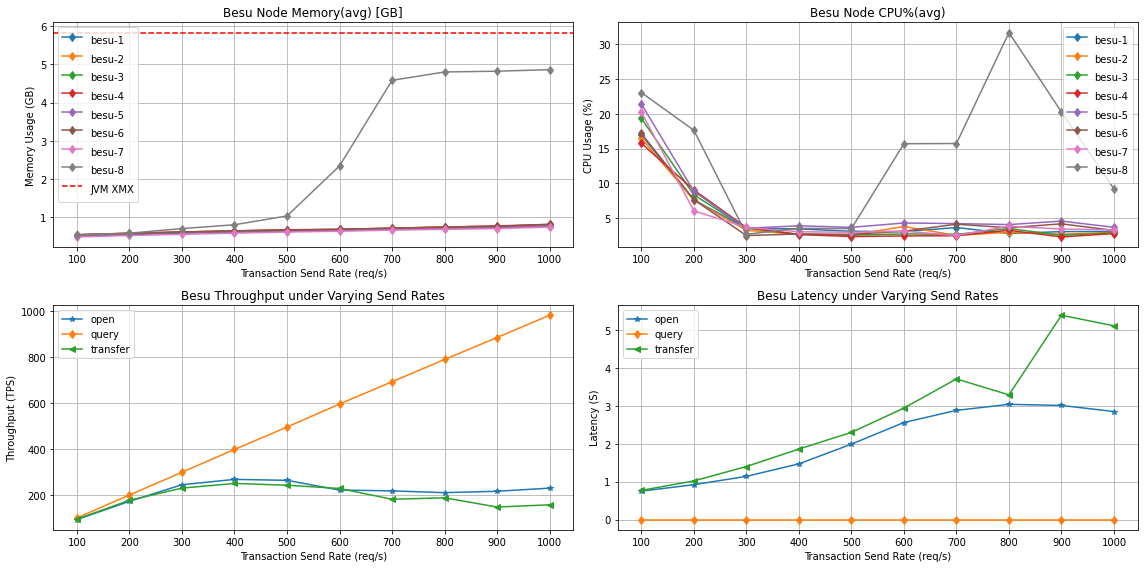

In [5]:
plot(reports_path='../caliper-benchmarks/reports/nlb-8n/20220406-190440')

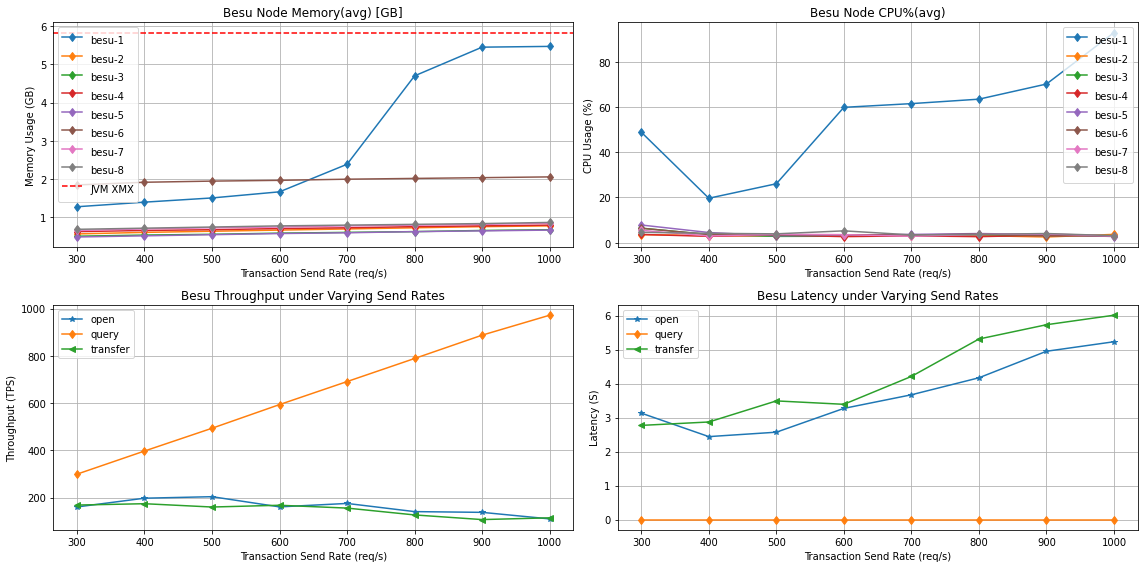

In [2]:
plot(reports_path='../caliper-benchmarks/reports/20220410-161516')

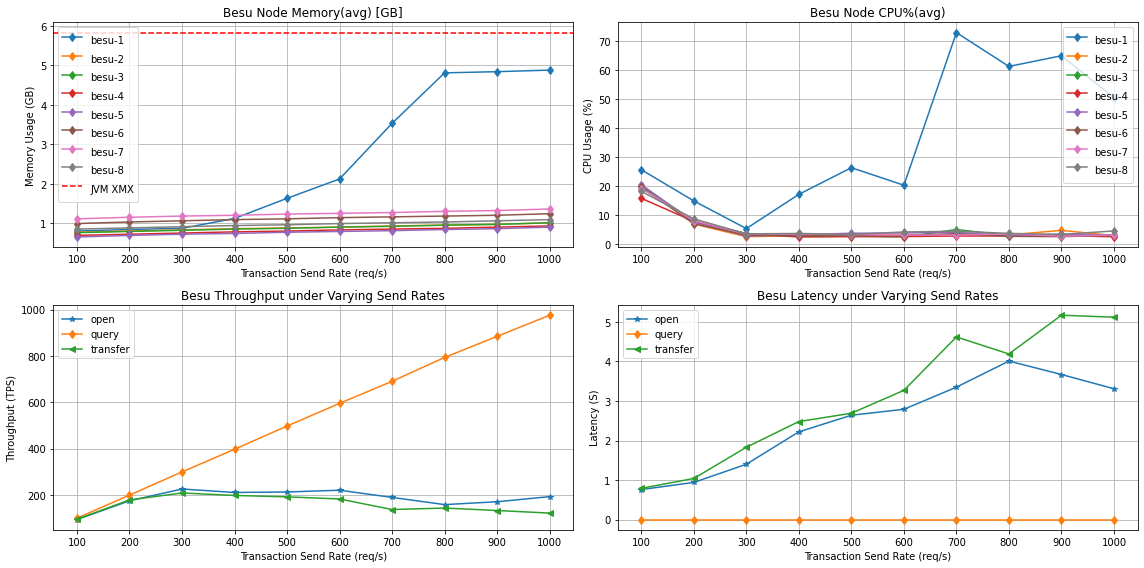

In [3]:
plot(reports_path='../caliper-benchmarks/reports/20220410-194554')

## Load Balance - 8nodes - 1s

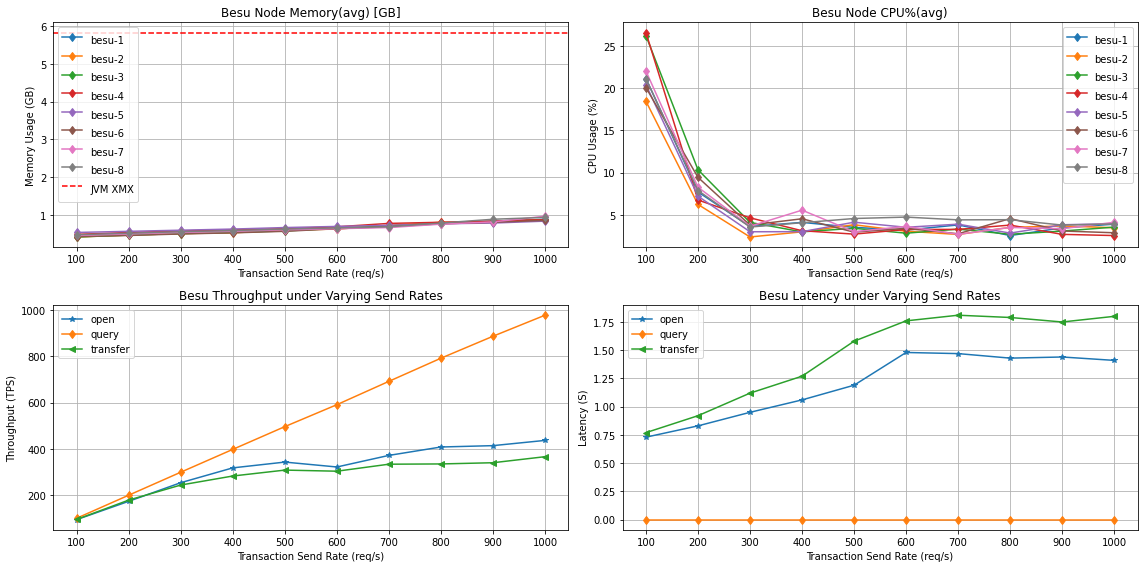

In [17]:
plot(reports_path='../caliper-benchmarks/reports/nlb-8n/20220407-011118')

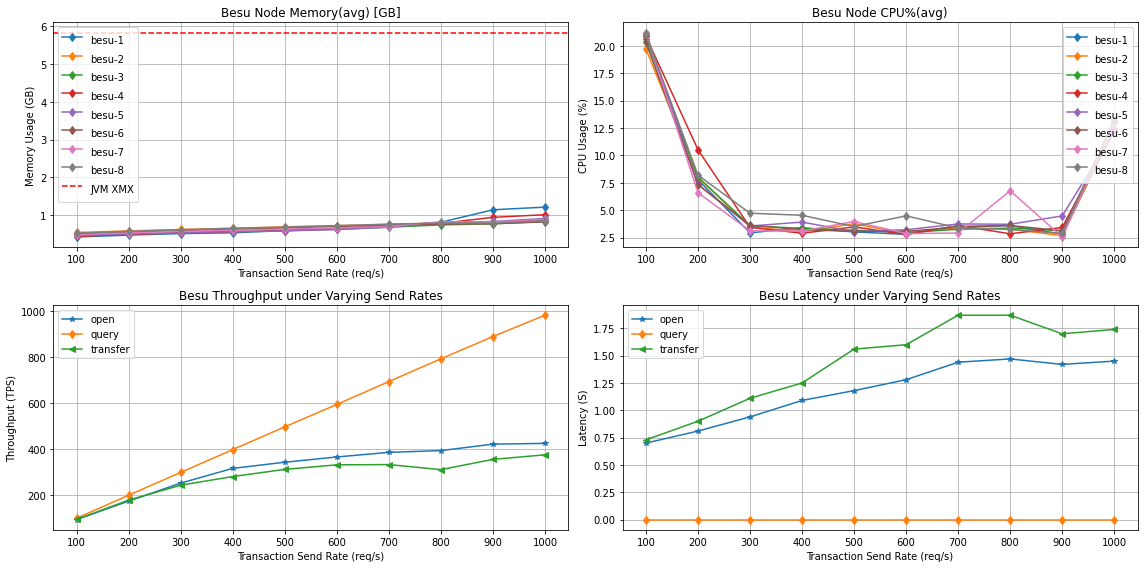

In [18]:
plot(reports_path='../caliper-benchmarks/reports/lb-8n/20220407-020925')

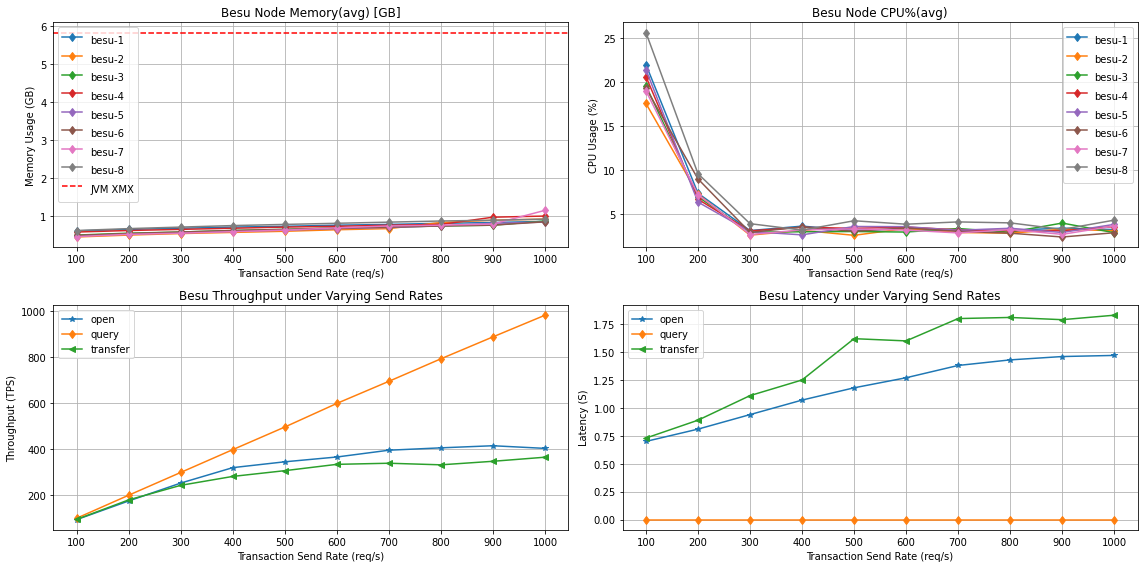

In [19]:
plot(reports_path='../caliper-benchmarks/reports/lb-8n/20220407-030732')

# QBFT

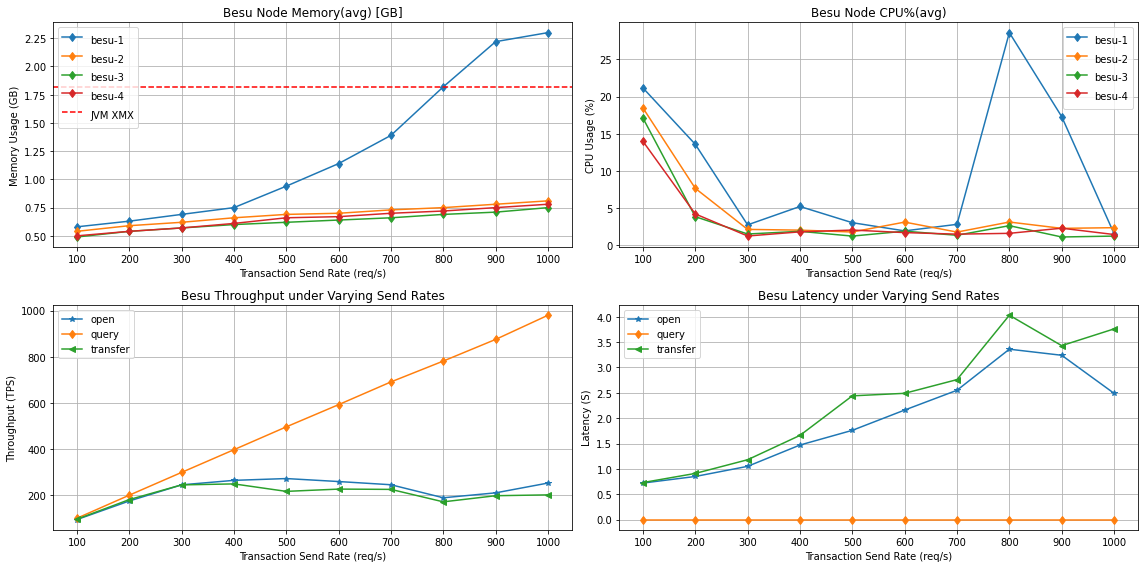

In [3]:
plot(reports_path='../caliper-benchmarks/reports/20220411-052552', jvm_max_heap=1.82)

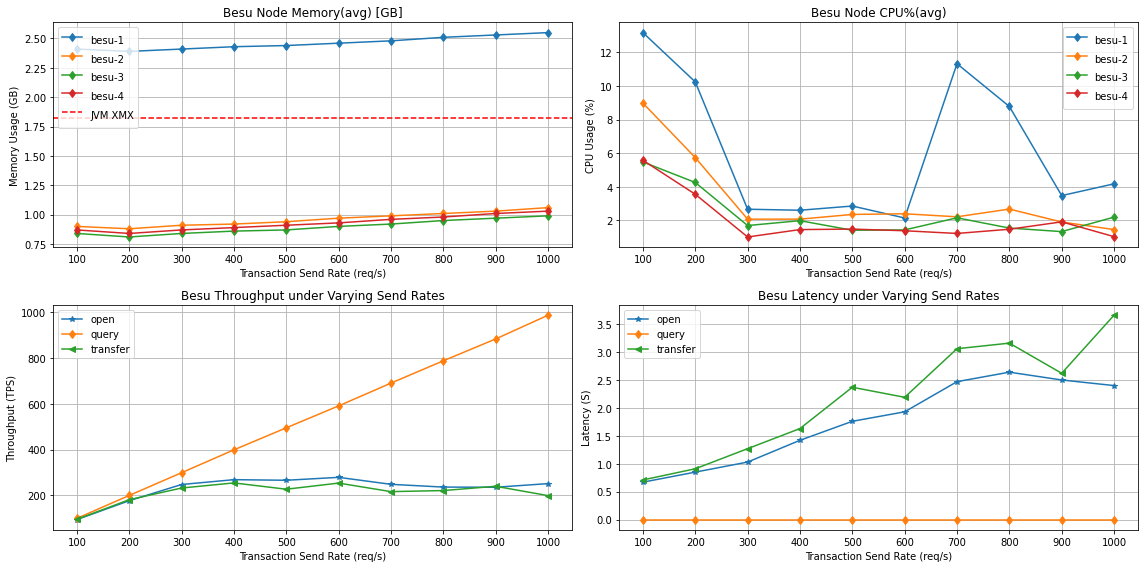

In [4]:
plot(reports_path='../caliper-benchmarks/reports/20220411-141819', jvm_max_heap=1.82)

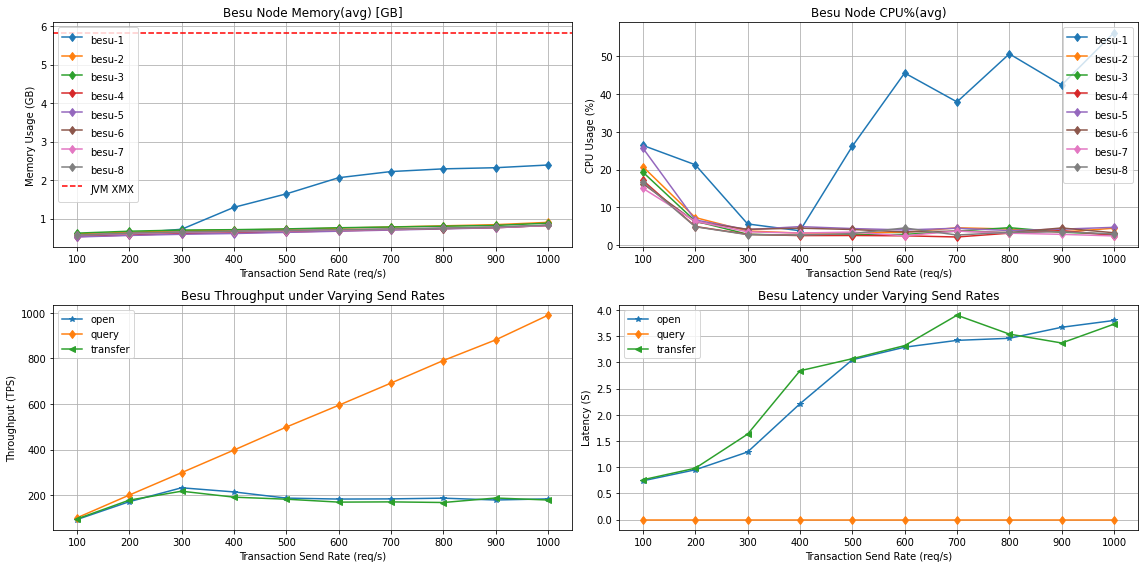

In [3]:
plot(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/reports_8_NLB_2C7.5G_QBFT_1S/20220412-031423/')

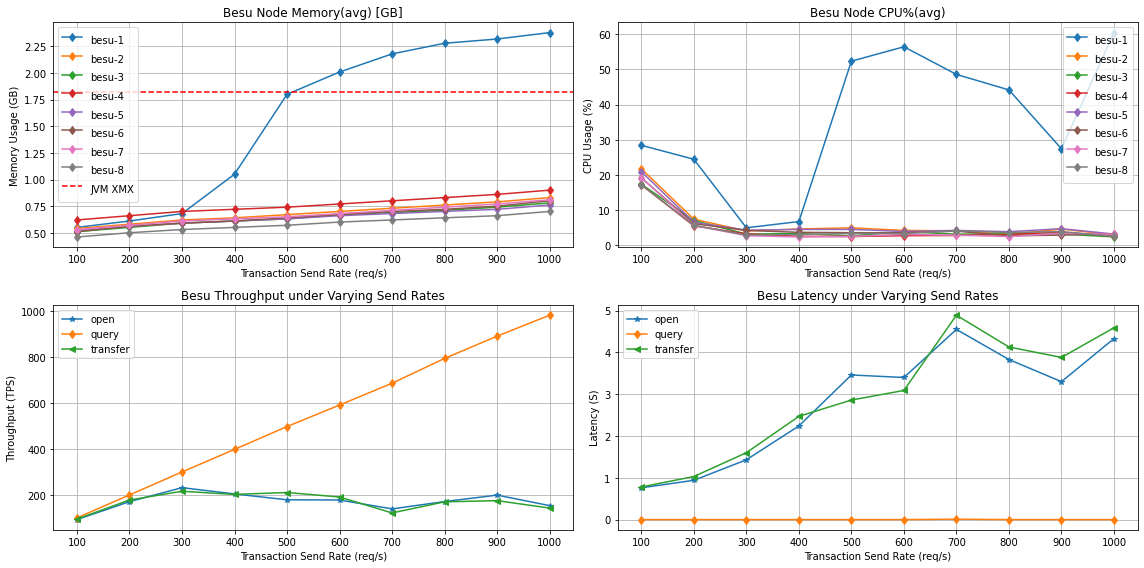

In [2]:
plot(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/reports_8_NLB_2C7.5G_QBFT_1S/20220412-021244/', jvm_max_heap=1.82)

In [ ]:
plot(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/reports_8_NLB_2C7.5G_QBFT_1S/20220412-135322/', jvm_max_heap=1.82)

# 4c-15gb

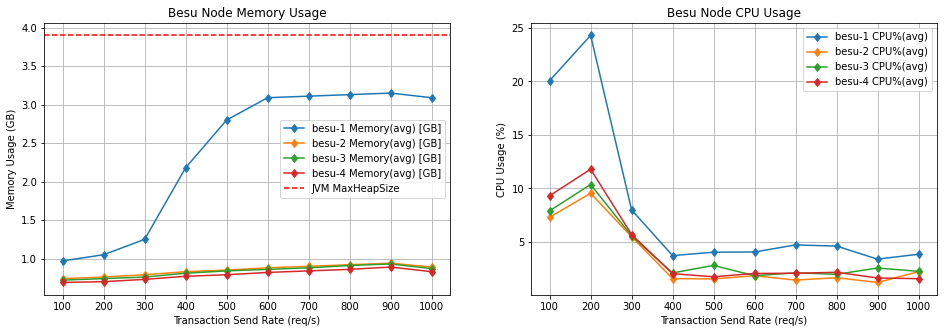

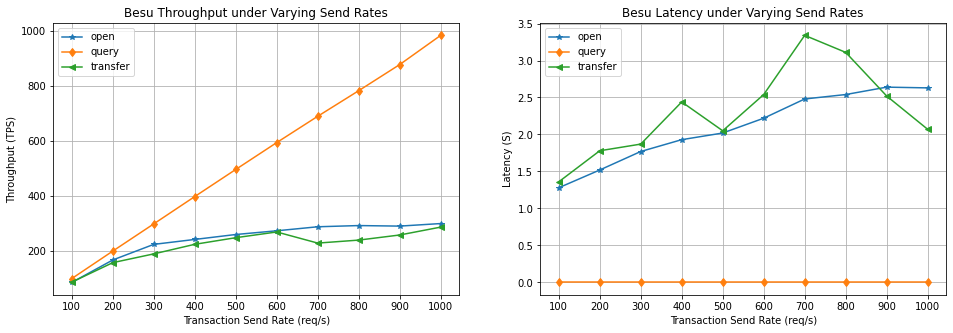

In [5]:
# 4c-15gb with maxrampercentage=80.0

plot(reports_path = '../caliper-benchmarks/reports/20220322-154306-4n-4c15gb-ram80')

# Cybera 4c-8gb

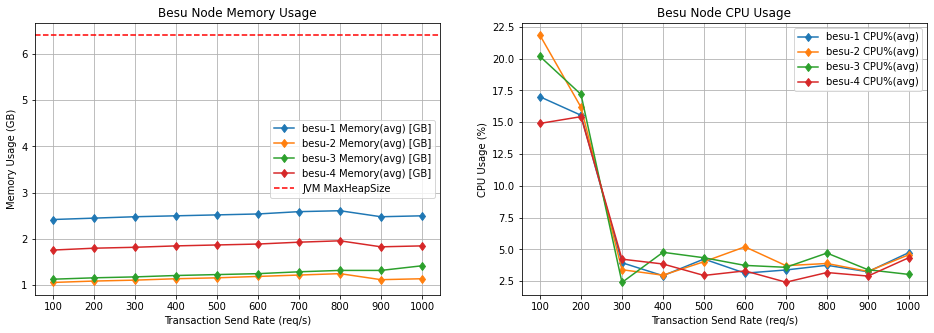

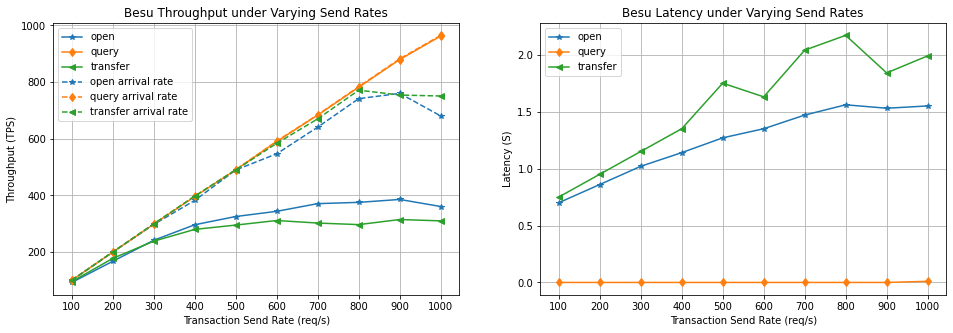

In [5]:
plot(reports_path = '../caliper-benchmarks/reports/20220402-180102')

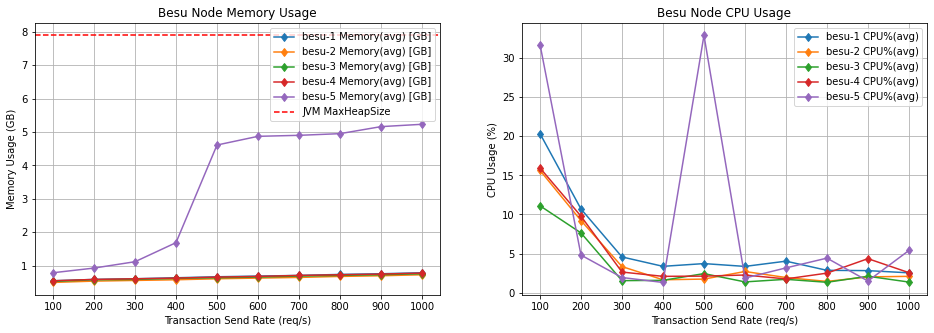

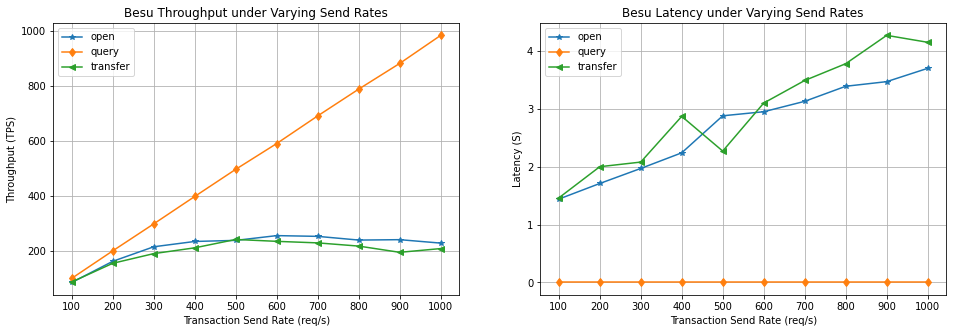

In [162]:
plot(reports_path = '../caliper-benchmarks/reports/20220223-215241-5-2sec')

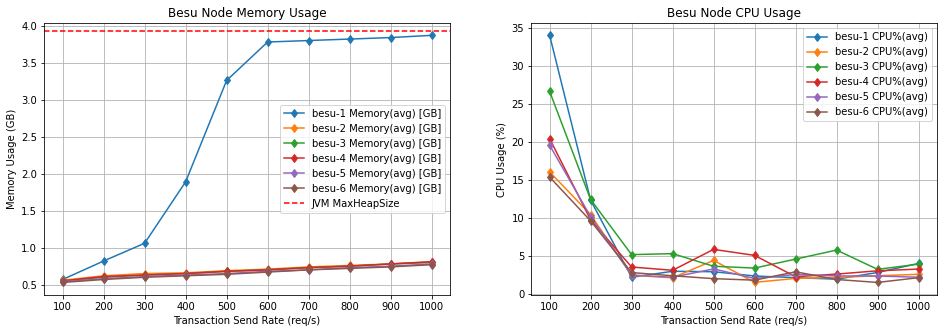

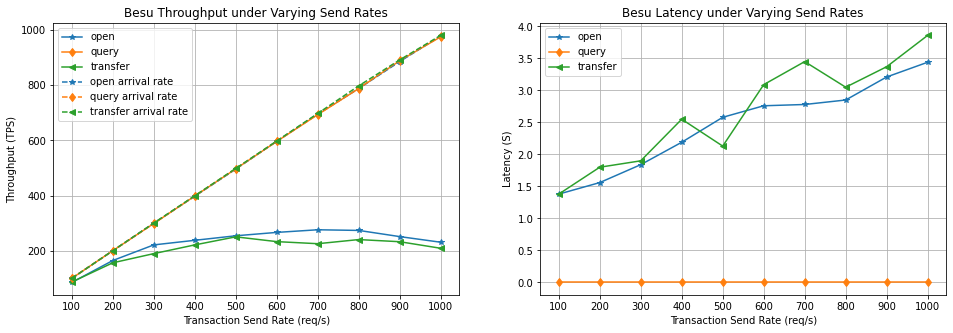

In [7]:
plot(reports_path = '../caliper-benchmarks/reports/20220224-001139-6-2sec')

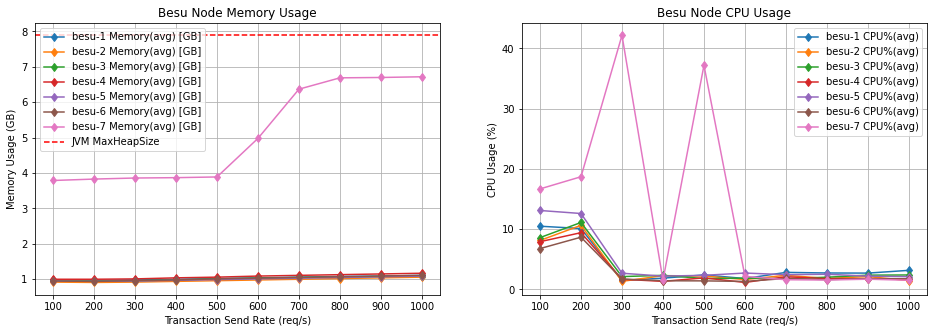

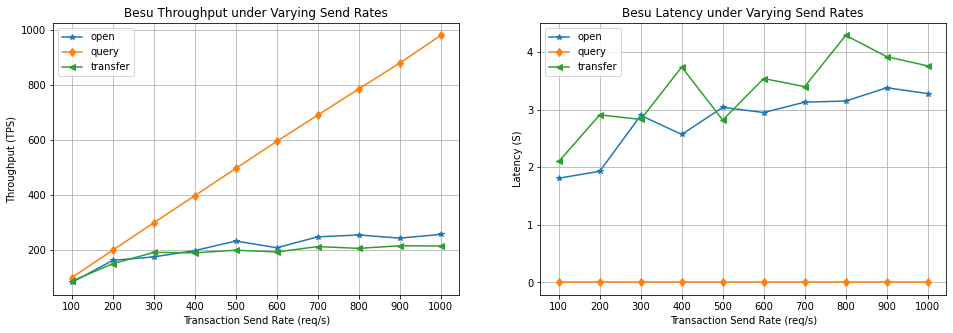

In [163]:
plot(reports_path = '../caliper-benchmarks/reports/20220224-205152-7-2sec')

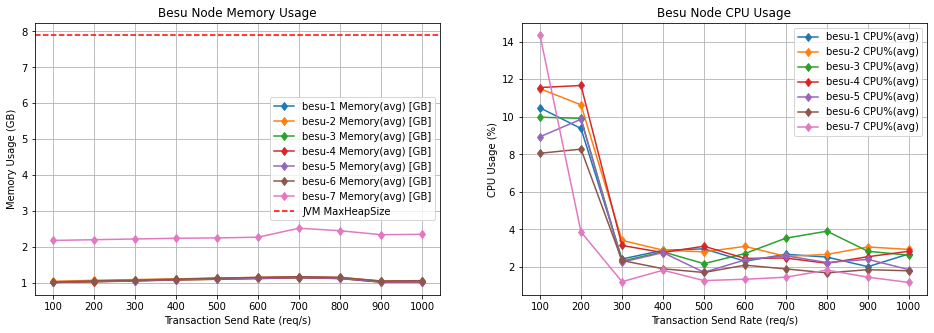

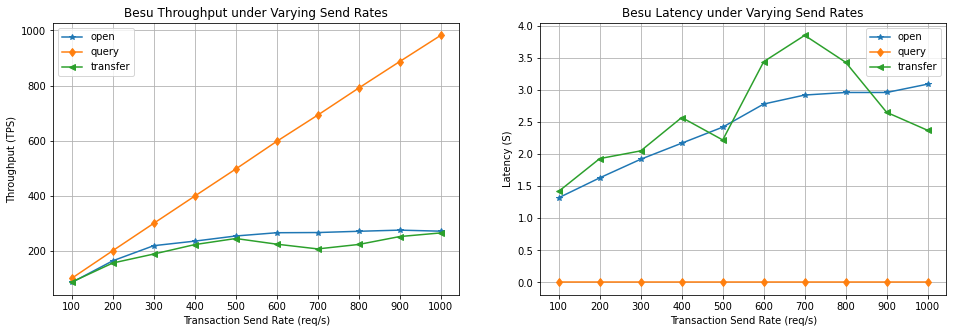

In [165]:
plot(reports_path = '../caliper-benchmarks/reports/20220225-203936-7-2sec')

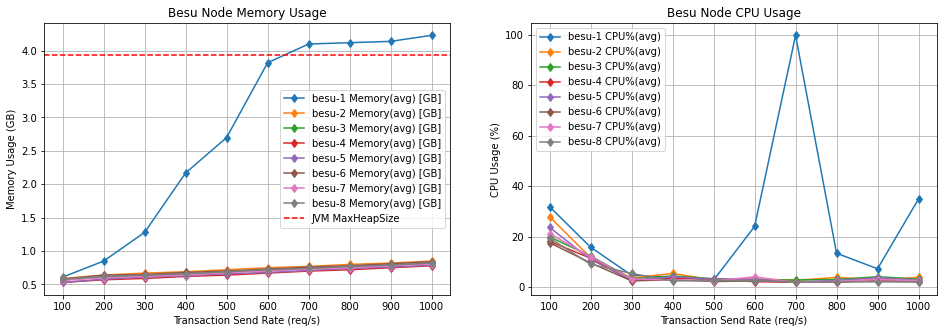

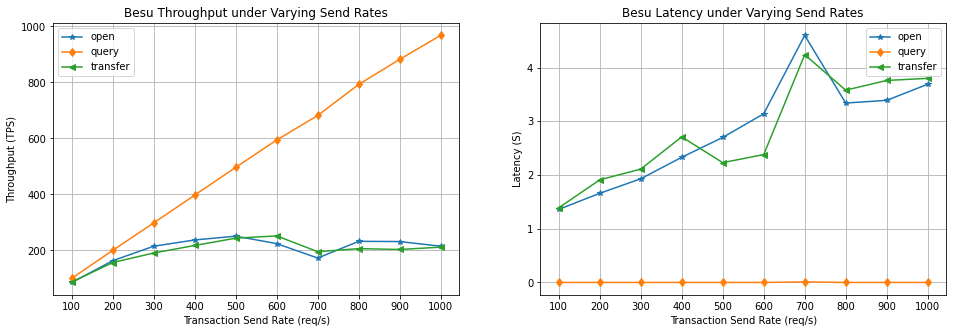

In [161]:
plot(reports_path = '../caliper-benchmarks/reports/20220224-015808-8-2sec')

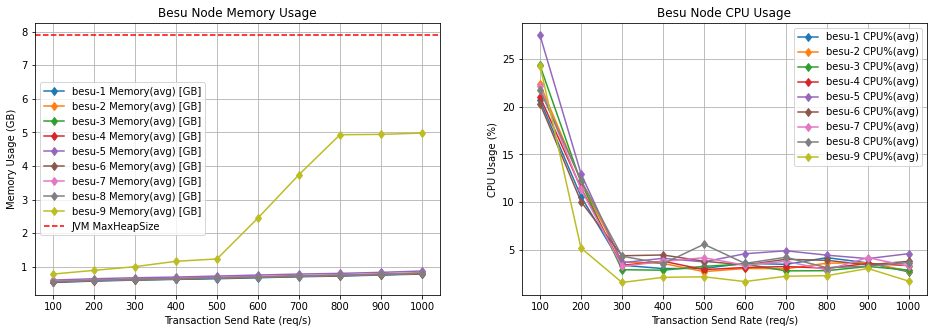

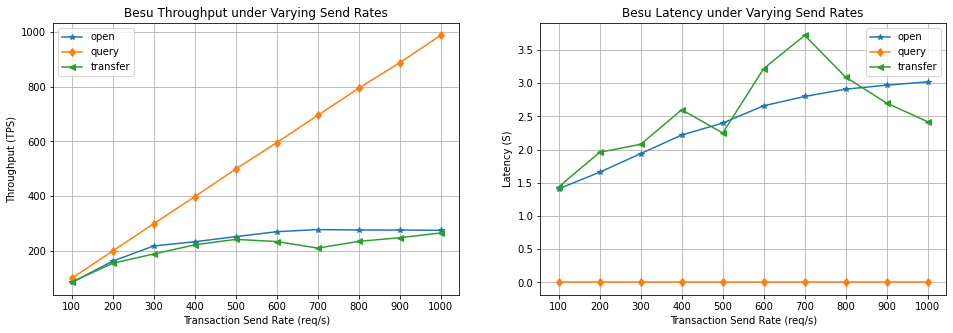

In [164]:
plot(reports_path = '../caliper-benchmarks/reports/20220224-222415-9-2sec')

In [4]:
path_reports_4nodes_1 = '../caliper-benchmarks/reports-20211129-152024'
path_reports_4nodes_2 = '../caliper-benchmarks/reports-20211130-140232'
path_reports_4nodes_3 = '../caliper-benchmarks/reports-20211130-162538'
sendrates = np.arange(50, 300, 50)
df_res_1 = get_res_df_single_round(path_reports_4nodes_1, sendrates)
df_res_2 = get_res_df_single_round(path_reports_4nodes_2, sendrates)
df_res_3 = get_res_df_single_round(path_reports_4nodes_3, sendrates)

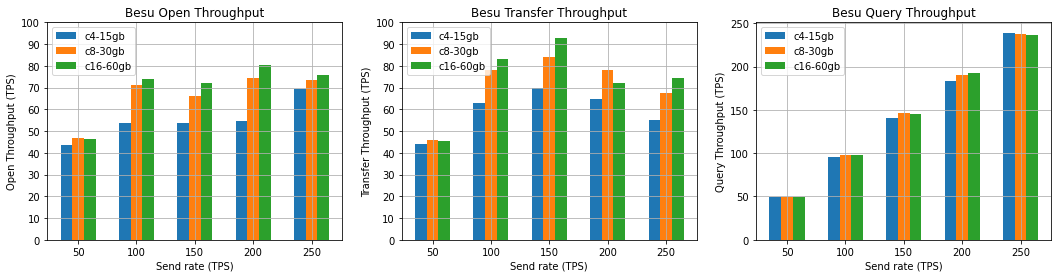

In [33]:
openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openTPS_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferTPS_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryTPS_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')

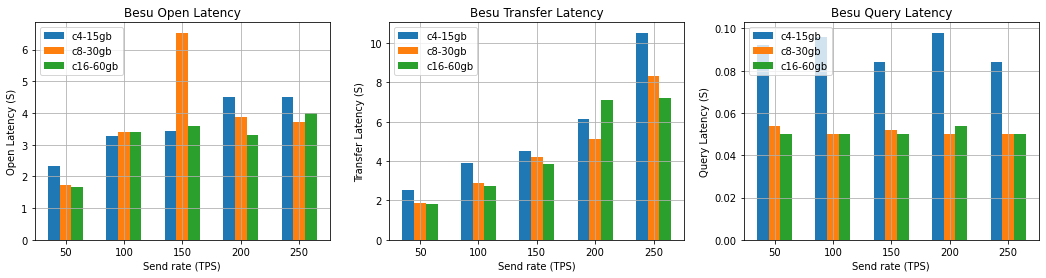

In [37]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openLatency_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferLatency_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryLatency_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

In [44]:
path_reports_4nodes_1 = '../caliper-benchmarks/reports/20211213-215339-2c4gb'
path_reports_4nodes_2 = '../caliper-benchmarks/reports/20211213-192953-4c8gb'
path_reports_4nodes_3 = '../caliper-benchmarks/reports/20211214-094805-8c8gb'
sendrates = np.arange(50, 300, 50)
df_res_1 = get_res_df_single_round(path_reports_4nodes_1, sendrates)
df_res_2 = get_res_df_single_round(path_reports_4nodes_2, sendrates)
df_res_3 = get_res_df_single_round(path_reports_4nodes_3, sendrates)

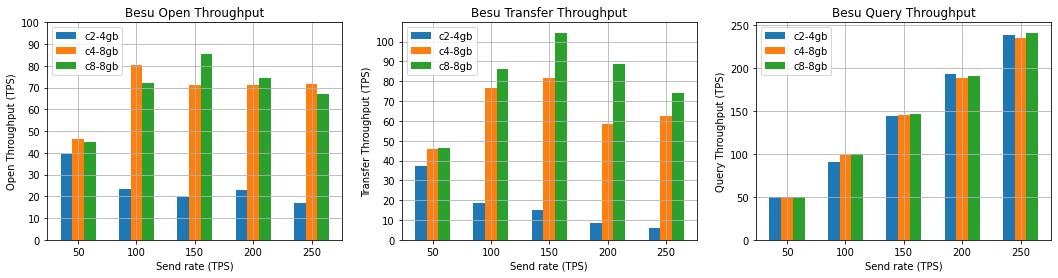

In [50]:
openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label='c2-4gb')
axs[0].bar(X_axis, openTPS_2, 0.2, label='c4-8gb')
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label='c8-8gb')
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label='c2-4gb')
axs[1].bar(X_axis, transferTPS_2, 0.2, label='c4-8gb')
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label='c8-8gb')
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label='c2-4gb')
axs[2].bar(X_axis, queryTPS_2, 0.2, label='c4-8gb')
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label='c8-8gb')
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')


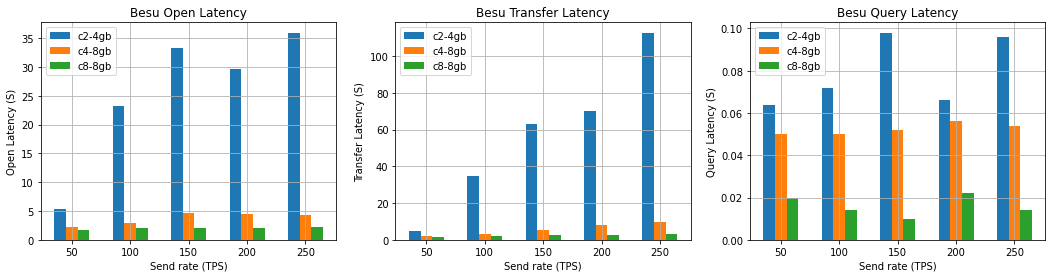

In [49]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label='c2-4gb')
axs[0].bar(X_axis, openLatency_2, 0.2, label='c4-8gb')
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label='c8-8gb')
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label='c2-4gb')
axs[1].bar(X_axis, transferLatency_2, 0.2, label='c4-8gb')
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label='c8-8gb')
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label='c2-4gb')
axs[2].bar(X_axis, queryLatency_2, 0.2, label='c4-8gb')
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label='c8-8gb')
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

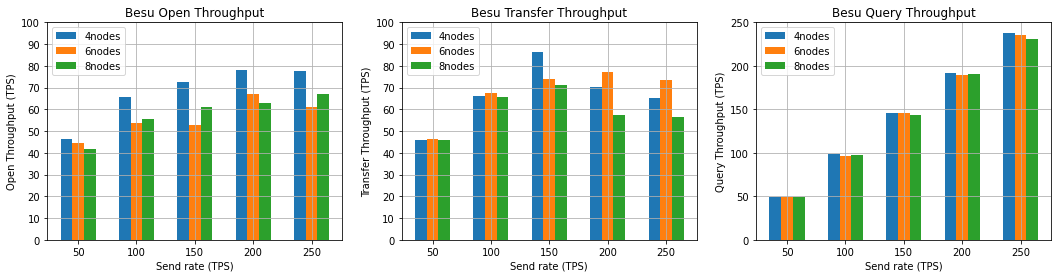

In [10]:
paths = ['../caliper-benchmarks/reports/20220126-200229-cyb-4', 
        '../caliper-benchmarks/reports/20220127-110556-cyb-6', 
        '../caliper-benchmarks/reports/20220127-144349-cyb-8']
sendrates = np.arange(50,300,50)
dfs = [get_res_df_single_round(path, sendrates) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)']
txTypes = ['open', 'query', 'transfer']
labels = ['4nodes', '6nodes', '8nodes']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')

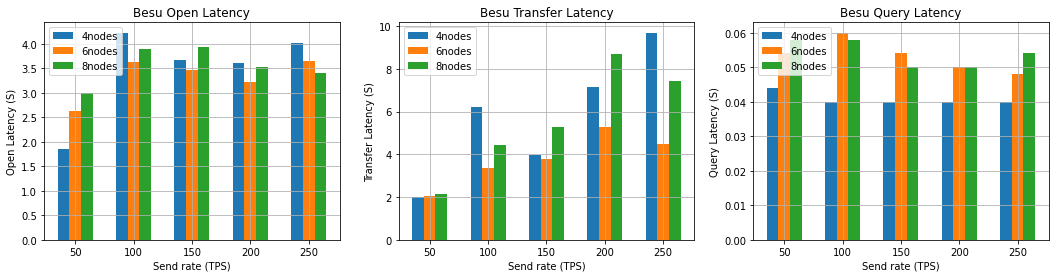

In [11]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

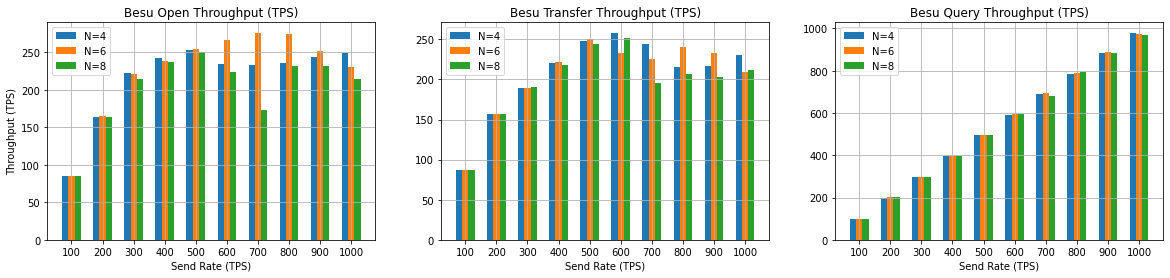

In [158]:
paths = ['../caliper-benchmarks/reports/20220223-163848-4-2sec', 
        '../caliper-benchmarks/reports/20220224-001139-6-2sec', 
        '../caliper-benchmarks/reports/20220224-015808-8-2sec']
dfs = [get_res_df_single_round(path) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=4', 'N=6', 'N=8']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
sendrates = sorted(df_res_1.Rate.unique().astype(int))
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

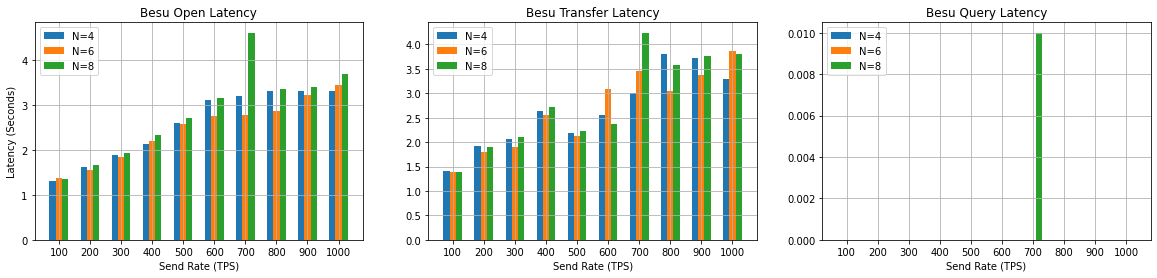

In [159]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# ax02 = axs[0].twinx()
# ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# ax12 = axs[1].twinx()
# ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# ax22 = axs[2].twinx()
# ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
# ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

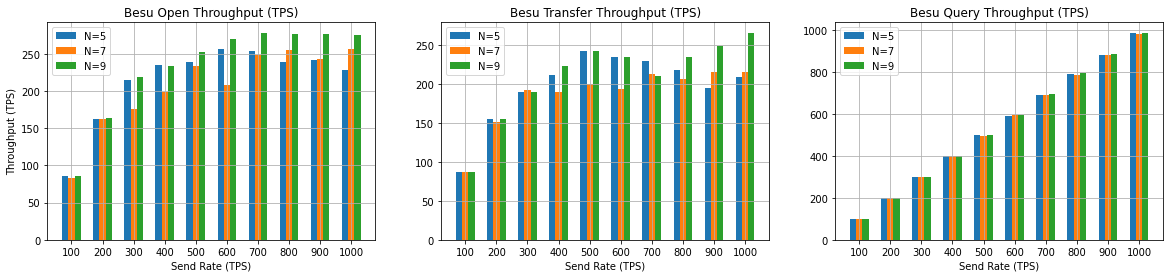

In [3]:
paths = ['../caliper-benchmarks/reports/20220223-215241-5-2sec', 
        '../caliper-benchmarks/reports/20220224-205152-7-2sec', 
        '../caliper-benchmarks/reports/20220224-222415-9-2sec']
dfs = [get_res_df_single_round(path) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=5', 'N=7', 'N=9']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
sendrates = sorted(df_res_1.Rate.unique().astype(int))
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

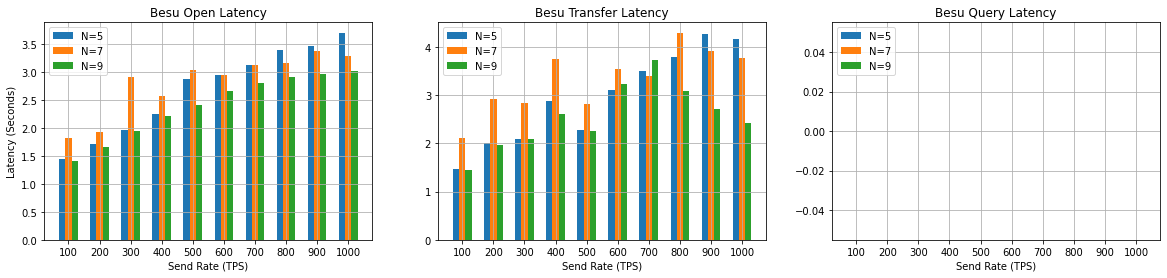

In [4]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# ax02 = axs[0].twinx()
# ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# ax12 = axs[1].twinx()
# ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# ax22 = axs[2].twinx()
# ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
# ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

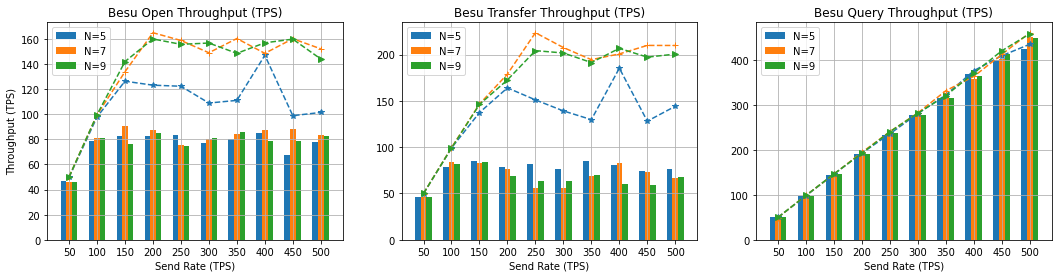

In [87]:
paths = ['../caliper-benchmarks/reports/20220209-115312-cc-5', 
        '../caliper-benchmarks/reports/20220211-223944-cc-7', 
        '../caliper-benchmarks/reports/20220212-130711-cc-9']
sendrates = np.arange(50,550,50)
dfs = [get_res_df_single_round(path, sendrates) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=5', 'N=7', 'N=9']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = [50 * (x+1) for x in X_axis]

axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

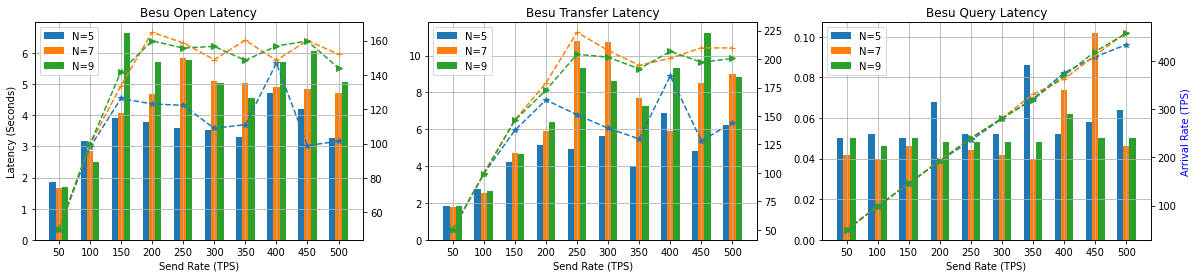

In [85]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = [50 * (x+1) for x in X_axis]

ax02 = axs[0].twinx()
ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

ax12 = axs[1].twinx()
ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

ax22 = axs[2].twinx()
ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

In [2]:
import pandas as pd

df = pd.read_csv('../data/TX_Num_ in_head_block.csv', parse_dates=True)
df.columns = ['Time', 'TX_num']

In [3]:
# 1450 1640
df = df[(df.Time > '2022-02-17 14:50:00') & (df.Time <= '2022-02-17 16:40:00')]

In [24]:
df

Time  TX_num
151  2022-02-17 14:50:20       0
152  2022-02-17 14:50:40       0
153  2022-02-17 14:51:00     100
154  2022-02-17 14:51:20       0
155  2022-02-17 14:51:40       0
..                   ...     ...
476  2022-02-17 16:38:40       0
477  2022-02-17 16:39:00       0
478  2022-02-17 16:39:20     186
479  2022-02-17 16:39:40       0
480  2022-02-17 16:40:00     308

[330 rows x 2 columns]

<AxesSubplot:>

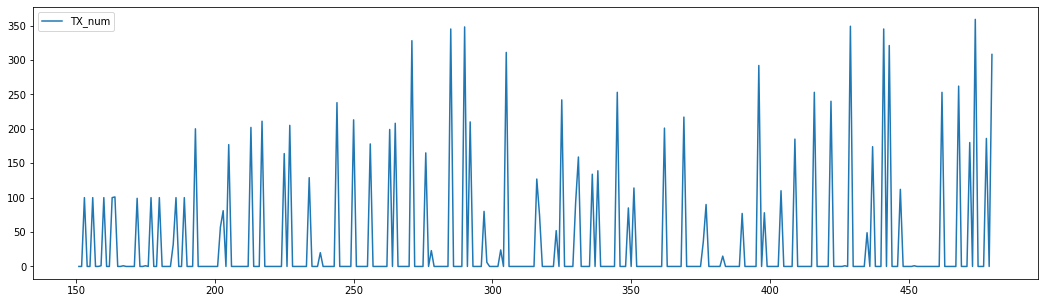

In [23]:
df.plot(figsize=(18,5))

<AxesSubplot:>

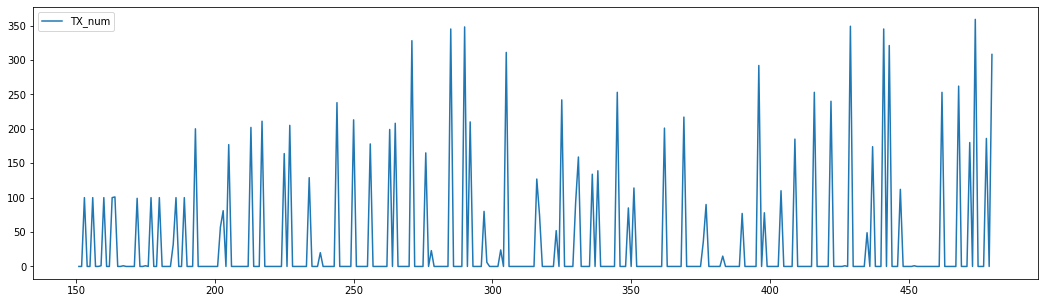

In [5]:
df[['Time', 'TX_num']].plot(figsize=(18,5))